### This is the second part of  our exploratory Data Analysis of 2016 primary elections.


Our primary objective is to analyze the reasons behind our party's defeat and identify strategies for enhancing our prospects of success in future elections. To accomplish this, we will undertake the following steps:

   * Investigate demographic data across various regions of the United States and detect and handle any outliers present in the dataset.
   * Delve into the primary election results by undertaking the following steps:
       * Assess the number of votes garnered by each party and make a comparison. Identify regions where our party received the fewest votes compared to the Republicans.
       * Analyze the locations where each candidate secured victories. Determine the regions with the strongest support for Donald Trump and examine the areas where Hillary Clinton faced significant setbacks.
       * Examine the geographical distribution of support for each candidate within each party. Specifically, we'll focus on understanding the areas of support for Donald Trump and analyze any variations. Similarly, we'll delve into Hillary Clinton's areas of weakness.
       
       
    

### Before main data exploration, here is a short summary of our analysis: 
We have 4 main candidates among the Republican party: Donald Trump, Ted Cruz, Marco Rubio and John Kasich and 2 main candidates in the Democratic party: Hillary Clinton and Bernie Sanders.
   While Hillary Clinton won the nomination with a narrow margin, Donald Trump secured a convincing victory among Republicans. Clinton's support was stronger in densely populated, urban areas, particularly in the South, while Sanders found more support in the North. Vulnerable states for our party include West Virginia, Washington, and Rhode Island, where Clinton had weak support and Trump was strong. Marco Rubio's performance stands with more educated, prosperous counties, while Trump's appeal spans across most demographics except for Hispanic or Latino populations. To improve chances, it's recommended to concentrate efforts in rural regions, especially in the Northwest, and target counties with high percentages of American Indian, Alaska native populations. Likewise, paying attention to areas with the high percent of high school graduates is essential.

### Now let's move to how we got these results:

Import the required modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
from typing import List, Union, Sequence, Optional
from matplotlib.ticker import FuncFormatter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib as mpl
from matplotlib.figure import Figure
from matplotlib.axes import Axes

Set plotting parameters:

In [2]:
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['axes.titlesize'] = 18
sns.set_style("white")
plt.style.use('seaborn')

Set a format for displaying floating point numbers in the dataframe

In [3]:
custom_format = lambda x: f'{x:.2f}'
pd.set_option('display.float_format', custom_format)

Define a function which customizes the bar chart:

In [4]:
def customize_bar(position: str = "v", *ax_args: Sequence[Axes]) -> None:
    """
    Function, which customizes bar chart
    Takes arbitrary number of Axes objects and:
        - gets rid of spines
        - modifies ticks
        - adds value above each bar
    Parameters:
        - *ax_args(Sequence[Axes]): list of Axes to modify
        - position(str): modify the bar depending on how the
        bars are positioned: vertically or horizontally
    Return: None
    """
    for ax in ax_args:
        # get rid of spines
        for spine in ax.spines.values():
            spine.set_visible(False)
        # modify ticklabels
        if position == "v":
            ax.set_yticks([])
            for tick in ax.get_xticklabels():
                tick.set_rotation(0)
        if position == "h":
            ax.set_xticks([])
            for tick in ax.get_yticklabels():
                tick.set_rotation(0)
        # add height value above each bar
        for bar in ax.patches:
            if position == "v":
                text_location = (bar.get_x() + bar.get_width()/2,
                                 bar.get_height() + 1/100*bar.get_height())
                value = round(bar.get_height(), 1)
                location = "center"
            elif position == "h":
                text_location = (bar.get_width(),
                                 bar.get_y() + bar.get_height() / 2)
                value = round(bar.get_width(), 1)
                location = "left"
            ax.text(text_location[0],
                    text_location[1],
                    str(value),
                    ha=location,
                    fontweight="bold")

Define the dimensionality reduction function that utilizes Principal Component Analysis technique. This function will be applied to correlated demographic columns of a given dataset.

In [5]:
def reduce_dimensions(columns: List[str],
                      df: pd.DataFrame) -> Union[pd.DataFrame, pd.Series]:
    """
    Function which applies Principal component analysis algorithm
    on the specified columns in a DataFrame.
    Apply dimensionality reduction technique and keep 85% of the
    total variance. At the end, print the loading of each column,
    in order to come up with the meaningful names for the resulting
    columns.
    Parameters:
        - columns(List[str]): list of columns to apply
        dimensionality reduction
        - df(DataFrame): DataFrame which contains the specified columns
    Return:
        - data_pca(Union[DataFrame, Series]): the resulting columns
    """
    data = df[columns]

    # standardize the data
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    # apply algorithm on 0 number of components
    pca = PCA()
    pca.fit_transform(data)

    # calculate cumulative variance ratio
    cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

    # determine the number of components to keep 85% of variance
    n_components = np.argmax(cumulative_variance_ratio >= 0.85) + 1

    # apply PCA with the selected number of components
    pca = PCA(n_components=n_components)
    data_pca = pca.fit_transform(data)

    for i, component in enumerate(pca.components_):
        print(f"Principal Component {i+1} Loadings:")
        for j, feature in enumerate(columns):
            print(f"{county_dictionary.loc[feature]}: {component[j]}")
        print()

    # Display the results
    print("Original Data Shape:", data.shape)
    print("Reduced Data Shape (PCA):", data_pca.shape)
    print("Number of Components Selected:", n_components)
    return data_pca

Load the tables:

In [6]:
county_facts = pd.read_csv("modified_data/county_facts.csv", index_col=0)
primary_results = pd.read_csv("modified_data/primary_results.csv")
county_dictionary = pd.read_csv("modified_data/county_dictionary.csv",
                                index_col=0).squeeze()

Design a function that accepts demographic data and presents it with columns renamed from their abbreviated forms to more descriptive names:

In [7]:
def display(table: Union[pd.DataFrame, pd.Series],
            columns: List[str] = []) -> Union[pd.DataFrame, pd.Series]:
    """
    Take the DataFrame or Series with the abbreviated demographic
    columns(indeces) and display it where they have meaningful names.
    Parameters:
        - table(Union[DataFrame, Series]): DataFrame or Series, where
        we rename columns
        - columns(List[str]): List of columns to rename
    Return:
        - Union[DataFrame, Series]: this DataFrame or Series with the
        renamed columns(indeces)
    """
    if isinstance(table, pd.DataFrame):
        if not columns:
            return table.rename(columns=county_dictionary)
        else:
            return table[columns].rename(columns=county_dictionary)
    elif isinstance(table, pd.Series):
        if not columns:
            return table.rename(index=county_dictionary)
        else:
            return table[columns].rename(index=county_dictionary)

Move information about the whole country to the Series:

In [8]:
usa_facts = county_facts.iloc[0]
display(usa_facts)

area_name                                                                 united states
state_abbreviation                                                                  USA
Population, 2014 estimate                                                     318857056
Population, 2010 (April 1) estimates base                                     308758105
Population, percent change - April 1, 2010 to July 1, 2014                         3.30
Population, 2010                                                              308745538
Persons under 5 years, percent, 2014                                               6.20
Persons under 18 years, percent, 2014                                             23.10
Persons 65 years and over, percent, 2014                                          14.50
Female persons, percent, 2014                                                     50.80
White alone, percent, 2014                                                        77.40
Black or African American alone,

Create a dataframe with information only about states and the District of Columbia:

In [9]:
# mask to extract states and the capital
states_capital = (
    (county_facts.iloc[1:].index % 1000 == 0)
    | (county_facts.iloc[1:]["state_abbreviation"] == "DC")
                 )
state_facts = (county_facts.iloc[1:][states_capital])

# make the names of states capitalized
state_facts["area_name"] = state_facts["area_name"].str.capitalize()
state_facts.head()

,area_name,state_abbreviation,PST045214,PST040210,PST120214,POP010210,AGE135214,AGE295214,AGE775214,SEX255214,...,SBO415207,SBO015207,MAN450207,WTN220207,RTN130207,RTN131207,AFN120207,BPS030214,LND110210,POP060210
fips,,,,,,,,,,,,,,,,,,,,,
1000,Alabama,AL,4849377,4780127,1.40,4779736,6.10,22.80,15.30,51.50,...,1.20,28.10,112858843,52252752,57344851,12364,6426342,13369,50645.33,94.40
2000,Alaska,AK,736732,710249,3.70,710231,7.40,25.30,9.40,47.40,...,0.00,25.90,8204030,4563605,9303387,13635,1851293,1518,570640.95,1.20
4000,Arizona,AZ,6731484,6392310,5.30,6392017,6.40,24.10,15.90,50.30,...,10.70,28.10,57977827,57573459,86758801,13637,13268514,26997,113594.08,56.30
5000,Arkansas,AR,2966369,2915958,1.70,2915918,6.50,23.80,15.70,50.90,...,2.30,24.50,60735582,29659789,32974282,11602,3559795,7666,52035.48,56.00
6000,California,CA,38802500,37254503,4.20,37253956,6.50,23.60,12.90,50.30,...,16.50,30.30,491372092,598456486,455032270,12561,80852787,83645,155779.22,239.10


In "county_facts" table, keep only information about counties

In [10]:
# mask the keeps only counties of the country
counties = (
    (county_facts.index % 1000 != 0)
    & (county_facts["state_abbreviation"] != "DC")
)
county_facts = county_facts[counties]

## Exploring and cleaning of demographic charachtersitic columns

Let's look into two columns: "Population, 2010 (April 1) estimates base" and "Population, 2010"

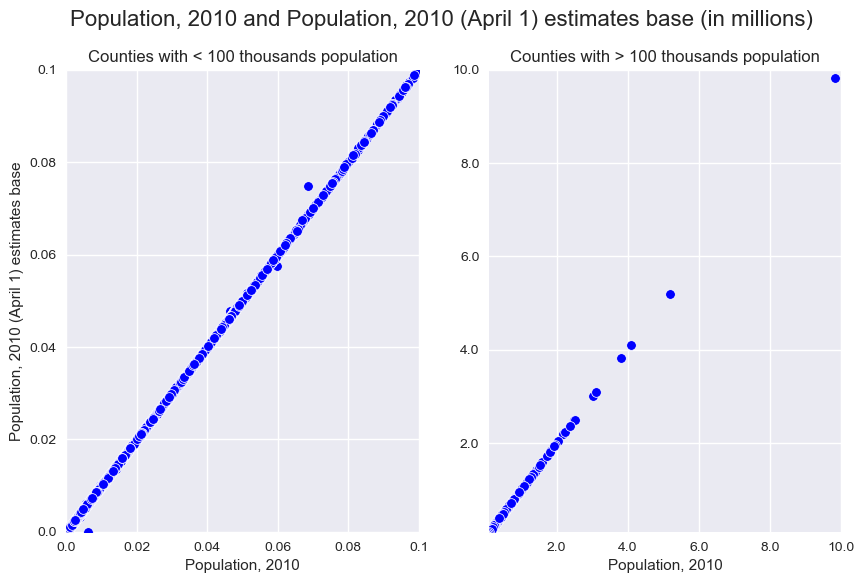

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
plt.suptitle(f"{county_dictionary.loc['POP010210']} "
             f"and {county_dictionary.loc['PST040210']} (in millions)",
             fontsize=16)

sns.scatterplot(x=county_facts["POP010210"],
                y=county_facts["PST040210"],
                ax=ax[0], color="blue")
ax[0].set_xlabel(county_dictionary.loc["POP010210"])
ax[0].set_ylabel(county_dictionary.loc["PST040210"])
ax[0].axis([0, 100000, 0, 100000])
ax[0].set_title("Counties with < 100 thousands population")

sns.scatterplot(x=county_facts["POP010210"],
                y=county_facts["PST040210"],
                ax=ax[1], color="blue")
ax[1].set_xlabel(county_dictionary.loc["POP010210"])
ax[1].set_ylabel("")
ax[1].axis([100000, 10000000, 100000, 10000000])
ax[1].set_title("Counties with > 100 thousands population")
ax[1].ticklabel_format(style="plain")

# modify the yticks
for axis in ax:
    axis.xaxis.set_major_formatter(FuncFormatter(lambda x, _: x / 1e6))
    axis.yaxis.set_major_formatter(FuncFormatter(lambda x, _: x / 1e6));

These 2 columns are identical. Therefore, let's drop one of them

In [12]:
county_dictionary.drop("PST040210", inplace=True)
state_facts.drop(columns="PST040210", inplace=True)
county_facts.drop(columns="PST040210", inplace=True)
usa_facts.drop("PST040210", inplace=True)

Let's categorize all the numerical columns into the same groups as those found on the census.gov website

In [13]:
facts_type = {"Population": ["PST045214", "PST120214", "POP010210"],
              "Age_sex": ["AGE135214", "AGE295214", "AGE775214", "SEX255214"],
              "Race": ["RHI125214", "RHI225214", "RHI325214", "RHI425214",
                       "RHI525214", "RHI625214", "RHI725214", "RHI825214"],
              "Education": ["EDU635213", "EDU685213"],
              "Housing": ["HSG010214", "HSG445213", "HSG096213", "HSG495213"],
              "Living_arr_family": ["HSD410213", "HSD310213",
                                    "POP715213", "POP815213"],
              "Pop_char": ["POP645213", "VET605213"],
              "Transportation": ["LFE305213"],
              "Income_poverty": ["INC910213", "INC110213", "PVY020213"],
              "Business": list(county_dictionary[
                  county_dictionary.index.str.contains("SBO")
              ].index) + ["BZA010213", "BZA110213", "BZA115213", "NES010213"],
              "Economy": ["MAN450207", "WTN220207", "RTN130207", "RTN131207",
                         "AFN120207", "BPS030214"],
              "Geography": ["LND110210", "POP060210"]}

 Analyze population columns:

In [14]:
pop_col_descr = county_facts[facts_type["Population"]].describe()
display(pop_col_descr)

,"Population, 2014 estimate","Population, percent change - April 1, 2010 to July 1, 2014","Population, 2010"
count,3142.00,3142.00,3142.00
mean,101272.49,0.46,98072.51
std,326027.45,4.19,312821.99
min,0.00,-17.00,82.00
25%,11024.75,-2.00,11100.25
50%,25702.00,-0.20,25849.00
75%,67689.50,2.20,66528.00
max,10116705.00,72.90,9818605.00


We've noticed a potential outlier with a population value of zero

In [15]:
# display county with the smallest population in 2014
display(county_facts.loc[county_facts["PST045214"].idxmin()])

area_name                                                                 bedford city
state_abbreviation                                                                  VA
Population, 2014 estimate                                                            0
Population, percent change - April 1, 2010 to July 1, 2014                        0.00
Population, 2010                                                                  6222
Persons under 5 years, percent, 2014                                              0.00
Persons under 18 years, percent, 2014                                             0.00
Persons 65 years and over, percent, 2014                                          0.00
Female persons, percent, 2014                                                     0.00
White alone, percent, 2014                                                        0.00
Black or African American alone, percent, 2014                                    0.00
American Indian and Alaska Native alone, pe

Bedford city appears to be an outlier as all of its data for the year 2014 is missing. Let's remove this row from the dataset

In [16]:
county_facts = county_facts.drop(index=county_facts["PST045214"].idxmin())

Let's revisit the population columns

Text(0.5, 0, '')

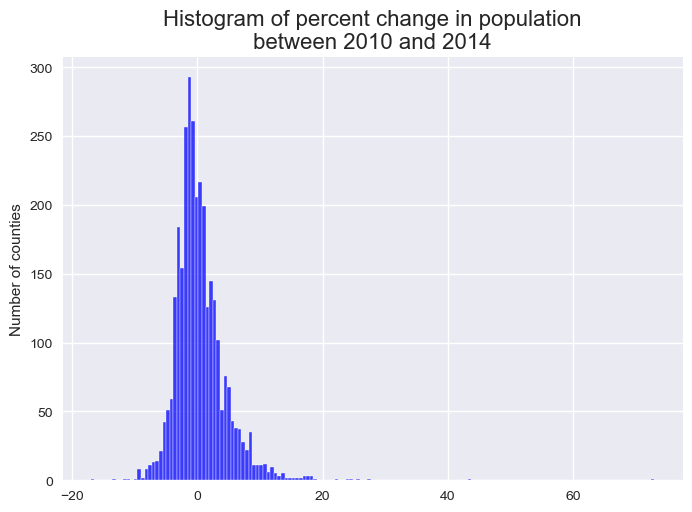

In [17]:
sns.histplot(x="PST120214", data=county_facts, color="blue")
plt.title("Histogram of percent change in population\nbetween 2010 and 2014",
          fontsize=16)
plt.ylabel("Number of counties")
plt.xlabel("")

Let's examine outliers in the population change column.

In [18]:
show_columns = ["area_name", "state_abbreviation"] + facts_type["Population"]

# sort the table by the population percent change
sorted_by_pop_pct = (county_facts[show_columns]
                     .sort_values(by="PST120214"))

# extract the lowest and highest values
lowest_values = sorted_by_pop_pct.head(5)
highest_values = sorted_by_pop_pct.tail(5)
keys = ["Lowest population percent change",
        "Highest population percent change"]

display(pd.concat([lowest_values, highest_values], keys=keys))

area_name state_abbreviation  \
                                  fips                                  
Lowest population percent change  40011     blaine                 OK   
                                  8011        bent                 CO   
                                  16033      clark                 ID   
                                  48377   presidio                 TX   
                                  35011    de baca                 NM   
Highest population percent change 38025       dunn                 ND   
                                  38089      stark                 ND   
                                  38061  mountrail                 ND   
                                  38105   williams                 ND   
                                  38053   mckenzie                 ND   

                                         Population, 2014 estimate  \
                                  fips                               
Lowest population percent change  40011                       9917   
                                  8011                        5630   
                                  16033                        867   
                                  48377                       6976   
                                  35011                       1825   
Highest population percent change 38025                       4399   
                                  38089                      30372   
                                  38061                       9782   
                                  38105                      32130   
                                  38053                      10996   

                                         Population, percent change - April 1, 2010 to July 1, 2014  \
                                  fips                                                                
Lowest population percent change  40011                                             -17.00            
                                  8011                                              -13.40            
                                  16033                                             -11.70            
                                  48377                                             -10.80            
                                  35011                                              -9.70            
Highest population percent change 38025                                              24.40            
                                  38089                                              25.50            
                                  38061                                              27.50            
                                  38105                                              43.50            
                                  38053                                              72.90            

                                         Population, 2010  
                                  fips                     
Lowest population percent change  40011             11943  
                                  8011               6499  
                                  16033               982  
                                  48377              7818  
                                  35011              2022  
Highest population percent change 38025              3536  
                                  38089             24199  
                                  38061              7673  
                                  38105             22398  
                                  38053              6360

We have observed that there are no outliers that need to be removed from the dataset in terms of population change.

For the population values: aggregate values by state and group them. The resulting sums should be comparable to the data in the state_facts table

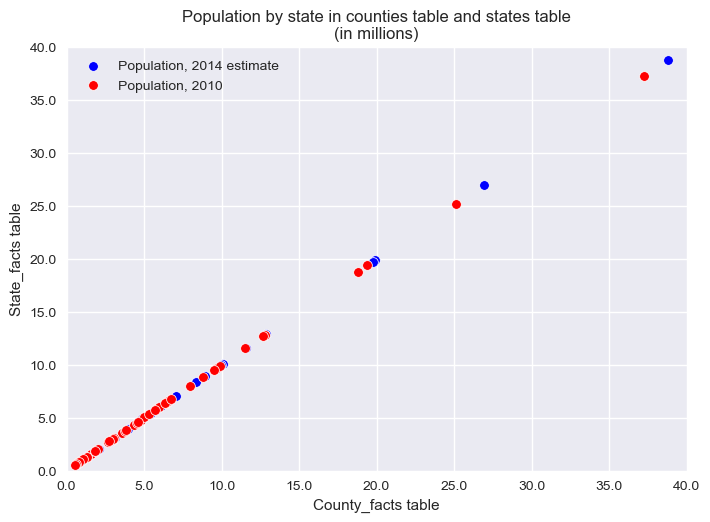

In [19]:
# sum population for all counties in each state
state_pop = (county_facts.groupby("state_abbreviation")
             [["PST045214", "POP010210"]].sum())

# merge the state poulation in county_facts and state_facts tables
state_county_pop = pd.merge(
    state_pop,
    state_facts[["state_abbreviation", "PST045214", "POP010210"]],
    on="state_abbreviation", how="inner")



sns.scatterplot(x=state_county_pop["PST045214_x"],
                y=state_county_pop["PST045214_y"],
                label="Population, 2014 estimate",
                color="blue")
sns.scatterplot(x=state_county_pop["POP010210_x"],
                y=state_county_pop["POP010210_y"],
                label="Population, 2010",
                color="red")
# customize the plot
plt.title("Population by state in counties"
          " table and states table\n(in millions)")
plt.xlabel("County_facts table")
plt.ylabel("State_facts table")
plt.ticklabel_format(style="plain")
plt.legend(loc="upper left")

# modify the x and y ticks
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: x / 1e6))
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: x / 1e6))

# set the limits
plt.xlim(0, 40000000)
plt.ylim(0, 40000000);

Let's remove the "Population in 2010" column since we already have columns for "Population in 2014" and "Population Change."

In [20]:
county_dictionary.drop("POP010210", inplace=True)
state_facts.drop(columns="POP010210", inplace=True)
county_facts.drop(columns="POP010210", inplace=True)
usa_facts.drop("POP010210", inplace=True)
facts_type["Population"].pop(-1);

#### Age-sex columns:

State_facts table:

In [21]:
age_sex = facts_type["Age_sex"]
display(state_facts[age_sex].describe())

,"Persons under 5 years, percent, 2014","Persons under 18 years, percent, 2014","Persons 65 years and over, percent, 2014","Female persons, percent, 2014"
count,51.00,51.00,51.00,51.00
mean,6.23,22.90,14.76,50.60
std,0.67,2.09,1.80,0.86
min,4.90,17.50,9.40,47.40
25%,6.00,21.75,14.15,50.25
50%,6.20,22.80,14.80,50.70
75%,6.50,23.95,15.75,51.20
max,8.60,30.70,19.10,52.60


There are no outliers detected in the state_facts table. All values fall within the expected range, and the standard deviation is low.

County_facts table:

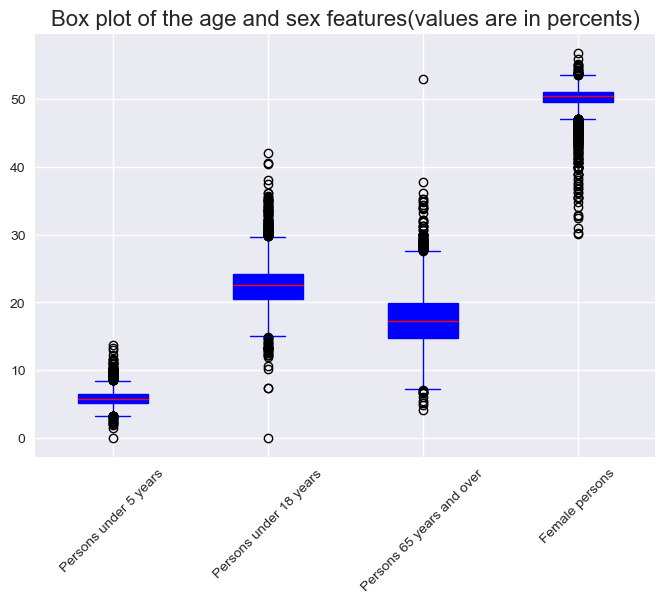

In [22]:
county_facts[age_sex].plot(kind="box",
                           patch_artist=True,
                           color="blue",
                           medianprops=dict(color="red"))
# extract xtick names and modify them
xticks = (county_dictionary
          .loc[age_sex]
          .apply(lambda x: x[: x.find(",")]))

plt.xticks(list(i for i in range(1, 5)),
           xticks, rotation=45)
plt.title("Box plot of the age and sex features(values are in percents)",
          fontsize=16);

Information on the county with 0 percent of people under 18:

In [23]:
display(county_facts.loc[county_facts["AGE295214"] == 0,
                         facts_type["Population"] + facts_type["Age_sex"]])

,"Population, 2014 estimate","Population, percent change - April 1, 2010 to July 1, 2014","Persons under 5 years, percent, 2014","Persons under 18 years, percent, 2014","Persons 65 years and over, percent, 2014","Female persons, percent, 2014"
fips,,,,,,
15005,89,-1.10,0.00,0.00,29.20,52.80


Information on the county with 0 percent of people under 5:

In [24]:
display(county_facts.loc[county_facts["AGE135214"] == 0,
                         facts_type["Population"] + facts_type["Age_sex"]])

,"Population, 2014 estimate","Population, percent change - April 1, 2010 to July 1, 2014","Persons under 5 years, percent, 2014","Persons under 18 years, percent, 2014","Persons 65 years and over, percent, 2014","Female persons, percent, 2014"
fips,,,,,,
15005,89,-1.10,0.00,0.00,29.20,52.80


Information on county with the highest percent of old people

In [25]:
max_age = county_facts["AGE775214"].max()
display(county_facts.loc[county_facts["AGE775214"] == max_age])

,area_name,state_abbreviation,"Population, 2014 estimate","Population, percent change - April 1, 2010 to July 1, 2014","Persons under 5 years, percent, 2014","Persons under 18 years, percent, 2014","Persons 65 years and over, percent, 2014","Female persons, percent, 2014","White alone, percent, 2014","Black or African American alone, percent, 2014",...,"Hispanic-owned firms, percent, 2007","Women-owned firms, percent, 2007","Manufacturers shipments, 2007 ($1,000)","Merchant wholesaler sales, 2007 ($1,000)","Retail sales, 2007 ($1,000)","Retail sales per capita, 2007","Accommodation and food services sales, 2007 ($1,000)","Building permits, 2014","Land area in square miles, 2010","Population per square mile, 2010"
fips,,,,,,,,,,,,,,,,,,,,,
12119,sumter,FL,114350,22.40,2.00,7.40,52.90,49.30,89.60,8.30,...,4.50,31.40,367864,0,672106,9244,79933,2570,546.93,170.80


No outliers need to be removed

#### Race:

In [26]:
race = facts_type["Race"]
display(state_facts[race].describe())

,"White alone, percent, 2014","Black or African American alone, percent, 2014","American Indian and Alaska Native alone, percent, 2014","Asian alone, percent, 2014","Native Hawaiian and Other Pacific Islander alone, percent, 2014","Two or More Races, percent, 2014","Hispanic or Latino, percent, 2014","White alone, not Hispanic or Latino, percent, 2014"
count,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00
mean,79.05,11.66,1.94,4.15,0.38,2.82,11.39,69.32
std,13.13,10.89,2.98,5.46,1.40,3.07,10.09,16.12
min,26.70,0.60,0.20,0.80,0.00,1.20,1.50,23.00
25%,72.25,3.50,0.50,1.65,0.10,1.80,4.80,58.30
50%,82.60,8.20,0.70,2.70,0.10,2.10,9.00,73.40
75%,87.85,16.20,1.60,4.50,0.20,2.60,13.00,80.95
max,95.00,49.00,14.80,37.50,10.00,23.00,47.70,93.80


No outliers in the state_facts table

For the county_facts table, sum the percentages of all races, (not Hispanic or Latino, and White alone, which are ethnicities, not races). The total should be approximately 100%.

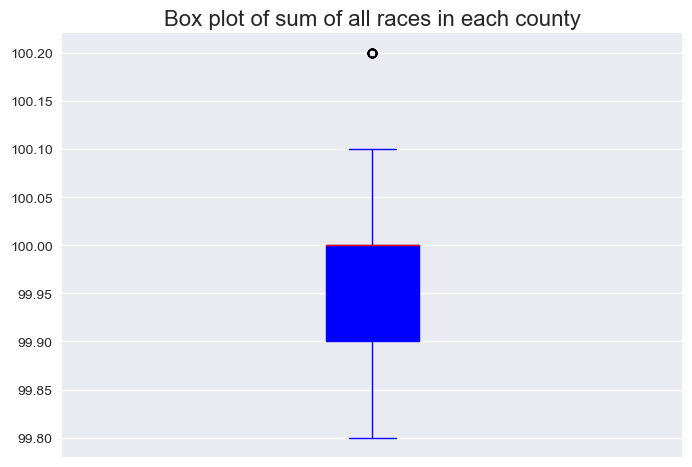

In [27]:
# sum races percents for each column
races_pct_sum = county_facts[facts_type["Race"][:6]].sum(axis=1)

# plot the boxplot
races_pct_sum.plot(kind="box", patch_artist=True,
                   color="blue", medianprops=dict(color="red"))
plt.title("Box plot of sum of all races in each county", fontsize=16)
plt.xticks([]);

The total percentage of all races adds up to approximately 100 for all regions, and there are no outliers in these columns.

Ethnicities

In [28]:
display(county_facts[["RHI725214", "RHI825214"]].describe())

,"Hispanic or Latino, percent, 2014","White alone, not Hispanic or Latino, percent, 2014"
count,3141.00,3141.00
mean,9.01,77.10
std,13.48,19.89
min,0.20,3.10
25%,2.10,65.50
50%,3.90,84.50
75%,9.20,93.10
max,95.80,98.60


In [29]:
show_columns = ["area_name", "state_abbreviation", "RHI725214", "RHI825214"]

# extract counties with the highest percent of latino people
sorted_by_hisp_lat = (county_facts[show_columns]
                      .sort_values(by="RHI725214", ascending=False)).head()

# counties with the lowest percent of white people
sorted_by_white = (county_facts[show_columns]
                   .sort_values(by="RHI825214", ascending=True)).head()

keys = ["Highest percent of hispanic or latino",
        "Lowest percent of white alone"]

display((pd.concat([sorted_by_hisp_lat, sorted_by_white], keys=keys)))

area_name  \
                                      fips                              
Highest percent of hispanic or latino 48427                     starr   
                                      48479                      webb   
                                      48323                  maverick   
                                      48505                    zapata   
                                      48507                    zavala   
Lowest percent of white alone         48323                  maverick   
                                      48479                      webb   
                                      48427                     starr   
                                      2270   wade hampton census area   
                                      46113                   shannon   

                                            state_abbreviation  \
                                      fips                       
Highest percent of hispanic or latino 48427                 TX   
                                      48479                 TX   
                                      48323                 TX   
                                      48505                 TX   
                                      48507                 TX   
Lowest percent of white alone         48323                 TX   
                                      48479                 TX   
                                      48427                 TX   
                                      2270                  AK   
                                      46113                 SD   

                                             Hispanic or Latino, percent, 2014  \
                                      fips                                       
Highest percent of hispanic or latino 48427                              95.80   
                                      48479                              95.20   
                                      48323                              95.10   
                                      48505                              93.90   
                                      48507                              93.00   
Lowest percent of white alone         48323                              95.10   
                                      48479                              95.20   
                                      48427                              95.80   
                                      2270                                1.10   
                                      46113                               3.70   

                                             White alone, not Hispanic or Latino, percent, 2014  
                                      fips                                                       
Highest percent of hispanic or latino 48427                                               3.80   
                                      48479                                               3.70   
                                      48323                                               3.10   
                                      48505                                               5.50   
                                      48507                                               6.20   
Lowest percent of white alone         48323                                               3.10   
                                      48479                                               3.70   
                                      48427                                               3.80   
                                      2270                                                4.90   
                                      46113                                               5.20

No outliers in ethnicity columns

#### Education:

In [30]:
education = ["EDU635213", "EDU685213"]
display(state_facts[education].describe())

,"High school graduate or higher, percent of persons age 25+, 2009-2013","Bachelor's degree or higher, percent of persons age 25+, 2009-2013"
count,51.00,51.00
mean,87.61,28.60
std,3.22,5.88
min,81.20,18.30
25%,84.80,25.15
50%,88.40,27.50
75%,90.40,31.35
max,92.40,52.40


All states exhibit high percentages of high school graduates with low standard deviation. However, the percentage of individuals with bachelor's degrees is notably lower, though still within an acceptable range.

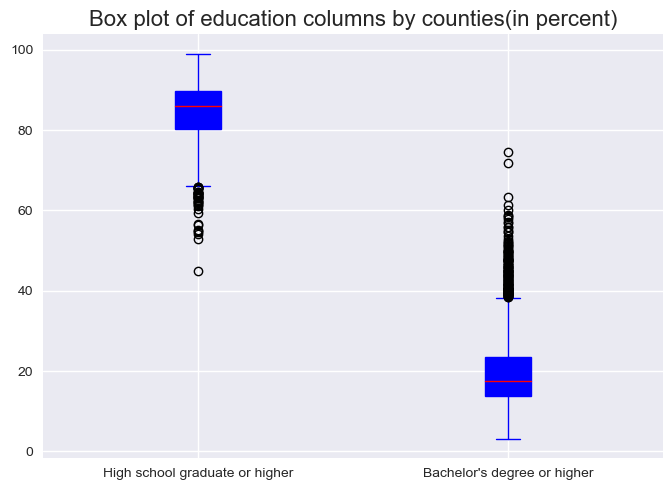

In [31]:
county_facts[education].boxplot(patch_artist=True, 
                                color="blue", 
                                medianprops=dict(color="red"))
plt.title("Box plot of education columns by counties(in percent)",
          fontsize=16)
xticks = (county_dictionary
          .loc[education]
          .apply(lambda x: x[: x.find(",")]))
          
plt.xticks(list(i for i in range(1, 3)), 
           xticks);

In [32]:
show_columns = ["area_name", "state_abbreviation"] + education

# counties with the lowest percet of high school graduates
sorted_by_high_school = (county_facts[show_columns]
                         .sort_values(by=education[0], ascending=True)).head(5)

# counties with the highest percent of people with Bachelor's
sorted_by_bachelor = (county_facts[show_columns]
                      .sort_values(by=education[1], ascending=False)).head(5)

keys = ["Lowest percent of high school graduates or higher",
        "Highest percent of people with at least Bachelor degree"]

display((pd.concat([sorted_by_high_school, sorted_by_bachelor], keys=keys)))

area_name  \
                                                   fips                       
Lowest percent of high school graduates or higher  48427              starr   
                                                   48283           la salle   
                                                   48229           hudspeth   
                                                   48377           presidio   
                                                   48505             zapata   
Highest percent of people with at least Bachelo... 51610  falls church city   
                                                   51013          arlington   
                                                   35028         los alamos   
                                                   51510    alexandria city   
                                                   24027             howard   

                                                         state_abbreviation  \
                                                   fips                       
Lowest percent of high school graduates or higher  48427                 TX   
                                                   48283                 TX   
                                                   48229                 TX   
                                                   48377                 TX   
                                                   48505                 TX   
Highest percent of people with at least Bachelo... 51610                 VA   
                                                   51013                 VA   
                                                   35028                 NM   
                                                   51510                 VA   
                                                   24027                 MD   

                                                          High school graduate or higher, percent of persons age 25+, 2009-2013  \
                                                   fips                                                                           
Lowest percent of high school graduates or higher  48427                                              45.00                       
                                                   48283                                              52.90                       
                                                   48229                                              54.00                       
                                                   48377                                              54.70                       
                                                   48505                                              54.80                       
Highest percent of people with at least Bachelo... 51610                                              97.30                       
                                                   51013                                              93.30                       
                                                   35028                                              97.00                       
                                                   51510                                              91.20                       
                                                   24027                                              94.90                       

                                                          Bachelor's degree or higher, percent of persons age 25+, 2009-2013  
                                                   fips                                                                       
Lowest percent of high school graduates or higher  48427                                               8.60                   
                                                   48283                                               5.10                   
                                                   48229                               

The least educated 5 counties are from Texas. Three of the most educated counties are from Virginia

#### Housing

In [33]:
housing = facts_type["Housing"]
display(state_facts[housing].describe())

,"Housing units, 2014","Homeownership rate, 2009-2013","Housing units in multi-unit structures, percent, 2009-2013","Median value of owner-occupied housing units, 2009-2013"
count,51.00,51.00,51.00,51.00
mean,2626611.37,66.43,23.86,194876.47
std,2763925.61,5.51,9.66,86767.98
min,268222.00,42.10,12.00,98500.00
25%,771301.00,65.25,17.90,131600.00
50%,1950382.00,67.50,20.70,165100.00
75%,2936179.50,69.75,25.60,238950.00
max,13900766.00,73.40,62.30,503100.00


Display the correlation of features:

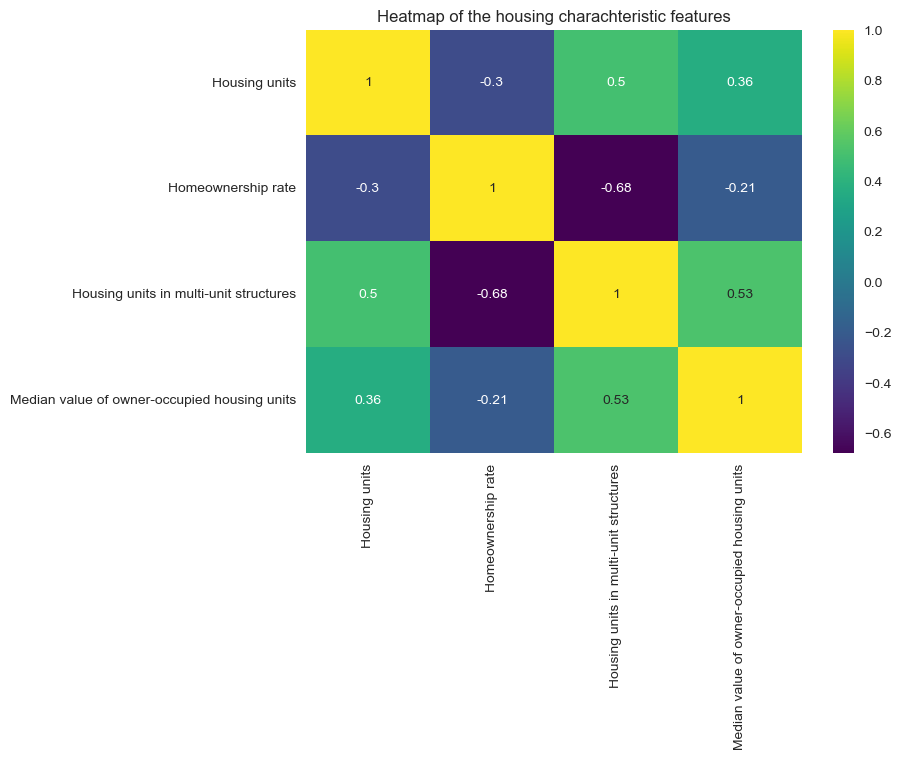

In [34]:
htmp = sns.heatmap(county_facts[housing].corr(),
                   annot=True, cmap="viridis")
ticklabels = [label[:label.find(",")]
              for label in county_dictionary.loc[housing]]
htmp.set_xticklabels(ticklabels, rotation=90)
htmp.set_yticklabels(ticklabels, rotation=0)
plt.title("Heatmap of the housing charachteristic features");

We don't have strongly correlated features

Homeownership rate and Housing units in multi-unit structures columns:

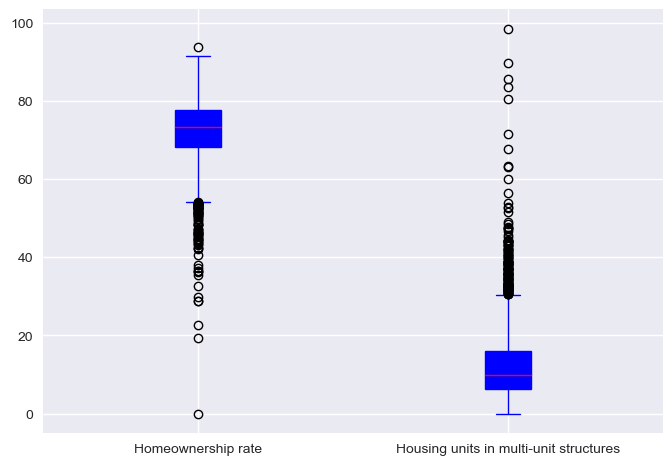

In [35]:
county_facts[housing[1:3]].boxplot(patch_artist=True,
                                   color="blue",
                                   medianprops=dict(color="red"))
xticks = (county_dictionary
          .loc[housing[1:3]]
          .apply(lambda x: x[: x.find(",")]))
plt.xticks(list(i for i in range(1, 3)), 
           xticks);

County with 0 in Homeownership rate

In [36]:
county_facts[county_facts[housing[1]] == 0]

,area_name,state_abbreviation,PST045214,PST120214,AGE135214,AGE295214,AGE775214,SEX255214,RHI125214,RHI225214,...,SBO415207,SBO015207,MAN450207,WTN220207,RTN130207,RTN131207,AFN120207,BPS030214,LND110210,POP060210
fips,,,,,,,,,,,,,,,,,,,,,
15005,kalawao,HI,89,-1.10,0.00,0.00,29.20,52.80,28.10,0.00,...,0.00,0.00,0,0,0,0,0,0,11.99,7.50


#### Living arrangments, family:

In [37]:
living_arr_family = facts_type["Living_arr_family"]
display(pd.concat([county_facts[living_arr_family].describe(),
                   state_facts[living_arr_family].describe()],
                  keys=["Counties", "State"]))

Households, 2009-2013  Persons per household, 2009-2013  \
Counties count                3141.00                           3141.00   
         mean                36721.99                              2.53   
         std                111136.63                              0.25   
         min                    33.00                              1.39   
         25%                  4232.00                              2.37   
         50%                  9781.00                              2.50   
         75%                 25658.00                              2.64   
         max               3230383.00                              4.70   
State    count                  51.00                             51.00   
         mean              2266866.98                              2.56   
         std               2409185.30                              0.16   
         min                222846.00                              2.20   
         25%                652792.00                              2.47   
         50%               1694996.00                              2.53   
         75%               2579636.50                              2.64   
         max              12542460.00                              3.12   

                Living in same house 1 year & over, percent, 2009-2013  \
Counties count                                            3141.00        
         mean                                               86.39        
         std                                                 4.40        
         min                                                50.80        
         25%                                                84.00        
         50%                                                86.90        
         75%                                                89.40        
         max                                                99.80        
State    count                                              51.00        
         mean                                               84.51        
         std                                                 2.37        
         min                                                77.70        
         25%                                                83.00        
         50%                                                84.70        
         75%                                                86.05        
         max                                                90.10        

                Language other than English spoken at home, pct age 5+, 2009-2013  
Counties count                                            3141.00                  
         mean                                                9.26                  
         std                                                11.53                  
         min                                                 0.00                  
         25%                                                 2.80                  
         50%                                                 5.00                  
         75%                                                10.30                  
         max                                                95.60                  
State    count                                              51.00                  
         mean                                               14.35                  
         std                                                 9.64                  
         min                                                 2.40                  
         25%                                                 6.80                  
         50%                                                10.70                  
         75%                                                19.80                  
         max                                                43.70

#### Population charachterisitcs:

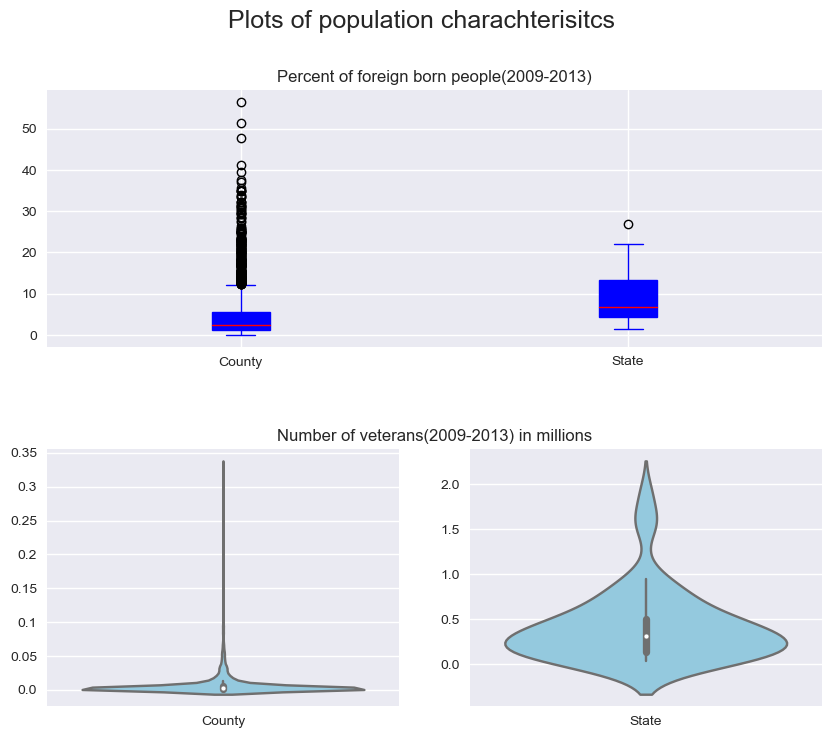

In [38]:
pop_char = ["POP645213", "VET605213"]

# create a grid for our plots
fig = plt.figure(figsize=(10, 8))
plt.subplots_adjust(hspace=0.4)
grid = plt.GridSpec(2, 2)
ax1 = fig.add_subplot(grid[0, :])

plt.suptitle("Plots of population charachterisitcs", fontsize=18)

# table of percent of foreign people for counties and states
foreigns_percents = pd.concat([county_facts[pop_char[0]], 
                               state_facts[pop_char[0]]], axis=1)

# plot the boxplots for both counties and states
foreigns_percents.boxplot(ax=ax1, patch_artist=True,
                          color="blue", 
                          medianprops=dict(color="red"))
ax1.set_title("Percent of foreign born people(2009-2013)")
ax1.set_xticklabels(["County", "State"])


# plot violinplots of number of veterans in states and counties
ax2 = fig.add_subplot(grid[1, 0])
sns.violinplot(y=county_facts[pop_char[1]], ax=ax2, color="skyblue")
ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, _: x / 1e6))
ax2.set_title("Number of veterans(2009-2013) in millions", x=1.1)
ax2.set_ylabel("")

ax3 = fig.add_subplot(grid[1, 1])
sns.violinplot(y=state_facts[pop_char[1]], ax=ax3, color="skyblue")
ax3.yaxis.set_major_formatter(FuncFormatter(lambda x, _: x / 1e6))
ax3.set_xticklabels([])
ax3.set_ylabel("")
ax2.set_xticklabels(["County"])
ax3.set_xticklabels(["State"]);

In [39]:
transportation = ["LFE305213"]
display(pd.concat([county_facts[transportation].describe(),
                   state_facts[transportation].describe()], 
                  keys=["Counties", "State"]))

Mean travel time to work (minutes), workers age 16+, 2009-2013
Counties count                                            3141.00             
         mean                                               22.97             
         std                                                 5.48             
         min                                                 4.40             
         25%                                                19.20             
         50%                                                22.80             
         75%                                                26.40             
         max                                                44.20             
State    count                                              51.00             
         mean                                               23.75             
         std                                                 3.54             
         min                                                16.90             
         25%                                                21.65             
         50%                                                23.80             
         75%                                                25.80             
         max                                                32.00

#### Business columns:

In [40]:
business = facts_type["Business"]
display(state_facts[business[:]].describe())

,"Total number of firms, 2007","Black-owned firms, percent, 2007","American Indian- and Alaska Native-owned firms, percent, 2007","Asian-owned firms, percent, 2007","Native Hawaiian- and Other Pacific Islander-owned firms, percent, 2007","Hispanic-owned firms, percent, 2007","Women-owned firms, percent, 2007","Private nonfarm establishments, 2013","Private nonfarm employment, 2013","Private nonfarm employment, percent change, 2012-2013","Nonemployer establishments, 2013"
count,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00
mean,534481.65,5.70,1.12,4.12,0.25,4.37,27.61,146830.45,2318946.14,1.69,451090.59
std,632455.20,6.25,1.68,6.75,1.32,5.47,2.43,162894.53,2560454.68,1.21,561281.38
min,55887.00,0.00,0.00,0.60,0.00,0.00,22.20,20519.00,212635.00,-1.10,46297.00
25%,151030.00,1.05,0.50,1.60,0.00,1.15,25.85,41690.50,563890.00,0.90,112151.50
50%,348154.00,3.40,0.60,2.10,0.00,2.40,27.40,97578.00,1507375.00,1.70,274987.00
75%,574065.00,8.80,0.95,4.25,0.10,4.70,29.05,174674.00,2809334.00,2.30,477238.50
max,3425510.00,28.20,10.00,47.20,9.50,23.60,34.50,874243.00,13401863.00,5.10,2983996.00


States with zero percent of black-owned firms:

In [41]:
display(state_facts[state_facts[business[1]] == 0][business])

,"Total number of firms, 2007","Black-owned firms, percent, 2007","American Indian- and Alaska Native-owned firms, percent, 2007","Asian-owned firms, percent, 2007","Native Hawaiian- and Other Pacific Islander-owned firms, percent, 2007","Hispanic-owned firms, percent, 2007","Women-owned firms, percent, 2007","Private nonfarm establishments, 2013","Private nonfarm employment, 2013","Private nonfarm employment, percent change, 2012-2013","Nonemployer establishments, 2013"
fips,,,,,,,,,,,
50000,78729,0.00,0.50,0.80,0.00,0.60,26.00,21119,262474,-1.10,59446
53000,551340,0.00,1.20,6.80,0.20,3.20,28.70,176815,2444098,3.50,413446
54000,120381,0.00,0.00,1.30,0.00,0.70,28.10,37573,575987,-0.60,88202


States with zero percent of asian-owned firms:

In [42]:
display(state_facts[state_facts[business[2]] == 0][business])

,"Total number of firms, 2007","Black-owned firms, percent, 2007","American Indian- and Alaska Native-owned firms, percent, 2007","Asian-owned firms, percent, 2007","Native Hawaiian- and Other Pacific Islander-owned firms, percent, 2007","Hispanic-owned firms, percent, 2007","Women-owned firms, percent, 2007","Private nonfarm establishments, 2013","Private nonfarm employment, 2013","Private nonfarm employment, percent change, 2012-2013","Nonemployer establishments, 2013"
fips,,,,,,,,,,,
10000,74573,8.70,0.00,4.00,0.00,2.10,26.10,24151,382128,5.10,56861
54000,120381,0.00,0.00,1.30,0.00,0.70,28.10,37573,575987,-0.60,88202


Business factors in counties table:

In [43]:
display(county_facts[facts_type["Business"]].describe())

,"Total number of firms, 2007","Black-owned firms, percent, 2007","American Indian- and Alaska Native-owned firms, percent, 2007","Asian-owned firms, percent, 2007","Native Hawaiian- and Other Pacific Islander-owned firms, percent, 2007","Hispanic-owned firms, percent, 2007","Women-owned firms, percent, 2007","Private nonfarm establishments, 2013","Private nonfarm employment, 2013","Private nonfarm employment, percent change, 2012-2013","Nonemployer establishments, 2013"
count,3141.00,3141.00,3141.00,3141.00,3141.00,3141.00,3141.00,3141.00,3141.00,3141.00,3141.00
mean,8768.18,2.38,0.59,0.80,0.02,1.69,17.94,2371.32,36504.83,0.68,7307.53
std,31548.56,6.87,3.81,2.54,0.35,6.23,12.85,8168.32,135198.92,5.91,28181.35
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-71.50,0.00
25%,903.00,0.00,0.00,0.00,0.00,0.00,0.00,221.00,2106.00,-1.80,737.00
50%,2155.00,0.00,0.00,0.00,0.00,0.00,23.20,539.00,6340.00,0.70,1636.00
75%,5641.00,0.00,0.00,0.00,0.00,0.00,27.80,1445.00,19716.00,3.00,4231.00
max,1046940.00,66.70,71.80,56.60,10.50,78.00,56.20,253227.00,3799831.00,110.80,945941.00


We see some counties have 0 number of firms. Let's look into them:

Text(0.5, 1.0, 'Scatter plot of population\nand total number of firms in each county')

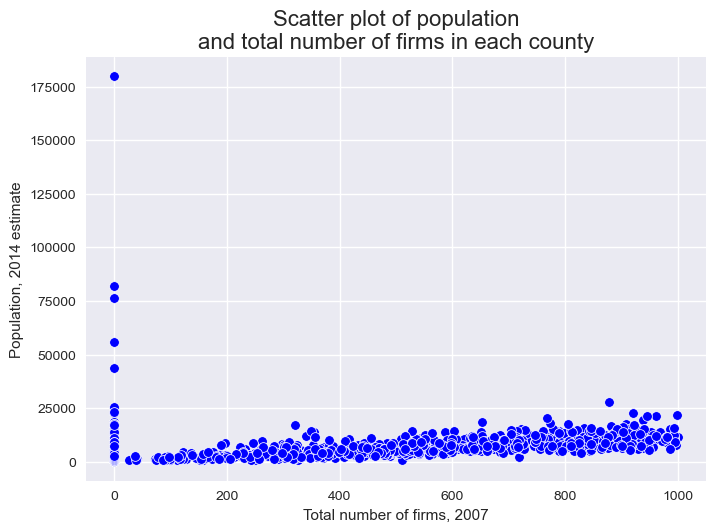

In [44]:
# extract counties with < 1000 firms
few_firms = county_facts[county_facts["SBO001207"] < 1000]

# scatterplot of number of firms and people in the county
sns.scatterplot(x="SBO001207", y=facts_type["Population"][0], 
                data=few_firms, color="blue")
plt.xlabel(county_dictionary.loc["SBO001207"])
plt.ylabel(county_dictionary.loc[facts_type["Population"][0]])
plt.title("Scatter plot of population\n"
          "and total number of firms in each county", fontsize=16)

Those counties with high population and 0 number of firms are potential outliers. Let's look into percent of firms owned by each race(females):

Create a function, which plots a figure with scatter plots of percent of race or gender in a county and percent of companies owned by this gender or race 

In [45]:
def scatterplot_race_firm(data: pd.DataFrame, 
                          hue: Optional[str] = None) -> tuple[Figure, plt, Axes]:
    """
    Function which takes the table and plots 6 scatter plots
    where the x axes is the percent of the race(female) in the county
    and the y axes is the percent of firms owned by this race(female) in
    the county. The races are: Black, Asian, American Indian and Alaska
    native, Native Hawaiian or other Pacific islander, Hispanic or Latino.
    Parameters:
        - data(DataFrame): table with the data to plot
        - hue(str): optional hue parameter, by which to group the values
        on some categorical column
    Retiurn:
        - tuple[Figure, plt, Axes]: the figure, pyplot and axes where 
        we performed the plotting
    """
    # set the palette depending on the hue parameter
    if not hue:
        palette = ["blue"]
    elif len(data[hue].unique()) == 2:
        palette = ["blue", "red"]
    elif len(data[hue].unique()) == 4:
        print("a")
        palette = ["blue", "red", "green", "orange"]
    with sns.color_palette(palette):
        fig, ax = plt.subplots(2, 3, figsize=(15, 10))
        sns.scatterplot(x="SBO315207", y="RHI225214", 
                        data=data, ax=ax[0, 0], hue=hue)
        sns.scatterplot(x="SBO115207", y="RHI325214", 
                        data=data, ax=ax[0, 1], hue=hue)
        sns.scatterplot(x="SBO215207", y="RHI425214", 
                        data=data, ax=ax[0, 2], hue=hue)
        sns.scatterplot(x="SBO515207", y="RHI525214", 
                        data=data, ax=ax[1, 0], hue=hue)
        sns.scatterplot(x="SBO415207", y="RHI725214", 
                        data=data, ax=ax[1, 1], hue=hue)
        sns.scatterplot(x="SBO015207", y="SEX255214", 
                        data=data, ax=ax[1, 2], hue=hue)
    # modify the labels
    for row in ax:
        for axis in row:
            xlabel = county_dictionary.loc[axis.get_xlabel()]
            ylabel = county_dictionary.loc[axis.get_ylabel()]
            xlabel = xlabel[:xlabel.find(",")]
            ylabel = ylabel[:ylabel.find(",")]
            axis.set_xlabel(xlabel)
            axis.set_ylabel(ylabel)
    return fig, plt, ax

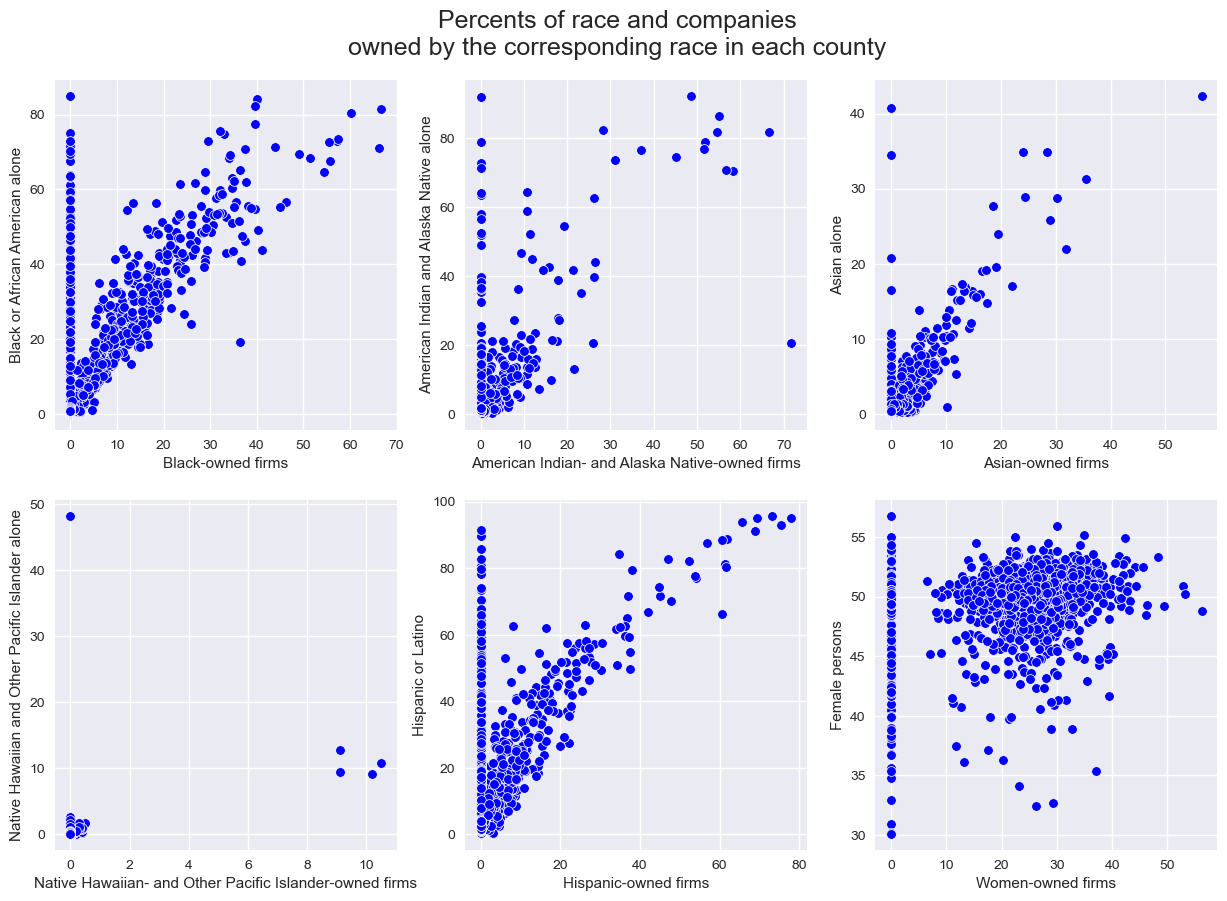

In [46]:
fig, plt, ax = scatterplot_race_firm(county_facts)
plt.suptitle("Percents of race and companies\n"
             "owned by the corresponding race in each county",
             fontsize=18, y=0.95);

 When examining a scatter plot depicting the relationship between the percentage of a specific race within a county and the percentage of businesses owned by individuals of that race, as well as the percentage of women and the percentage of women-owned companies, certain outliers become apparent. The majority of data points exhibit a correlation, which is expected. However, there are instances in certain counties where a high percentage of a particular race or gender corresponds to a 0% ownership of businesses by individuals of that race or gender.

Let's look into the counties which have such values:

In [47]:
display(county_facts[county_facts["SBO001207"] == 0]
        [facts_type["Population"] + business].sort_values(
            by=facts_type["Population"][0], ascending=False)).head()

,"Population, 2014 estimate","Population, percent change - April 1, 2010 to July 1, 2014","Total number of firms, 2007","Black-owned firms, percent, 2007","American Indian- and Alaska Native-owned firms, percent, 2007","Asian-owned firms, percent, 2007","Native Hawaiian- and Other Pacific Islander-owned firms, percent, 2007","Hispanic-owned firms, percent, 2007","Women-owned firms, percent, 2007","Private nonfarm establishments, 2013","Private nonfarm employment, 2013","Private nonfarm employment, percent change, 2012-2013","Nonemployer establishments, 2013"
fips,,,,,,,,,,,,,
6089,179804,1.50,0,0.00,0.00,0.00,0.00,0.00,0.00,4126,47159,1.50,11542
13127,82175,3.20,0,0.00,0.00,0.00,0.00,0.00,0.00,2427,29435,1.50,6218
18043,76179,2.10,0,0.00,0.00,0.00,0.00,0.00,0.00,1777,26086,-3.40,5001
20169,55755,0.30,0,0.00,0.00,0.00,0.00,0.00,0.00,1566,27280,0.70,3472
1021,43931,0.70,0,0.00,0.00,0.00,0.00,0.00,0.00,703,7396,8.80,2719


These rows have outliers, therefore, we drop them

In [48]:
county_facts = county_facts[county_facts["SBO001207"] != 0]

Let's look into correlation of the following business features: 
   * Total number of firms
   * Private nonfarm establishments 
   * Private nonfarm employment
   * Private nonfarm employment
   * Nonemployer establishments

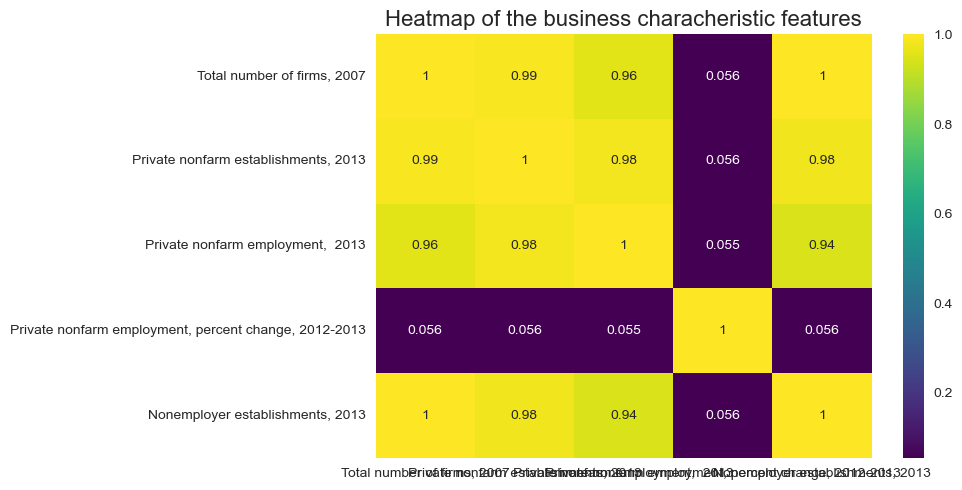

In [49]:
columns = ["SBO001207", "BZA010213", "BZA110213", "BZA115213", "NES010213"]

# display a heatmap
htmp = sns.heatmap(county_facts[columns].corr(), 
                   annot=True, cmap="viridis")

htmp.set_xticklabels(county_dictionary.loc[columns], rotation=0)
htmp.set_yticklabels(county_dictionary.loc[columns], rotation=0)
plt.title("Heatmap of the business characheristic features", 
          fontsize=16);

We see 4 columns to be strongly correlated. Let's apply dimensionality reduction on these columns 

In [50]:
# extract private nonfarm employment column(which is not correlated)
columns.pop(-2)

new_columns_county = reduce_dimensions(df=county_facts, columns=columns)

Principal Component 1 Loadings:
Total number of firms, 2007: 0.5025258829661727
Private nonfarm establishments, 2013: 0.5032511988450682
Private nonfarm employment,  2013: 0.4948909707270475
Nonemployer establishments, 2013: 0.49928838851200064

Original Data Shape: (2965, 4)
Reduced Data Shape (PCA): (2965, 1)
Number of Components Selected: 1


Create the name of the new column:

In [51]:
new_col = "nonfarm_business_activity"

Drop the reduced columns:

In [52]:
county_dictionary = county_dictionary.drop(columns)
county_facts = county_facts.drop(columns=columns)
facts_type["Business"] = list(
    filter(lambda x: x not in columns, facts_type["Business"]))

Add the new columns:

In [53]:
county_facts.loc[:, new_col] = new_columns_county

In [54]:
facts_type["Business"].extend([new_col])
facts_type["Business"]

['SBO315207',
 'SBO115207',
 'SBO215207',
 'SBO515207',
 'SBO415207',
 'SBO015207',
 'BZA115213',
 'nonfarm_business_activity']

#### Income and poverty:

In [55]:
income_poverty = facts_type["Income_poverty"]
display(pd.concat([county_facts[income_poverty].describe(),
         state_facts[income_poverty].describe()], keys=["Counties", "State"]))

Per capita money income in past 12 months (2013 dollars), 2009-2013  \
Counties count                                            2965.00                     
         mean                                            23646.86                     
         std                                              5596.58                     
         min                                              8768.00                     
         25%                                             19910.00                     
         50%                                             22897.00                     
         75%                                             26264.00                     
         max                                             62498.00                     
State    count                                              51.00                     
         mean                                            28053.80                     
         std                                              4659.38                     
         min                                             20618.00                     
         25%                                             24908.50                     
         50%                                             26824.00                     
         75%                                             30144.00                     
         max                                             45290.00                     

                Median household income, 2009-2013  \
Counties count                             2965.00   
         mean                             46079.46   
         std                              12047.49   
         min                              19986.00   
         25%                              38138.00   
         50%                              44262.00   
         75%                              51393.00   
         max                             122238.00   
State    count                               51.00   
         mean                             53530.27   
         std                               8780.43   
         min                              39031.00   
         25%                              46861.50   
         50%                              51843.00   
         75%                              59149.50   
         max                              73538.00   

                Persons below poverty level, percent, 2009-2013  
Counties count                                          2965.00  
         mean                                             16.75  
         std                                               6.44  
         min                                               3.60  
         25%                                              12.20  
         50%                                              16.00  
         75%                                              20.40  
         max                                              53.20  
State    count                                            51.00  
         mean                                             14.77  
         std                                               3.16  
         min                                               8.70  
         25%                                              12.15  
         50%                                              15.00  
         75%                                              17.55  
         max                                              22.70

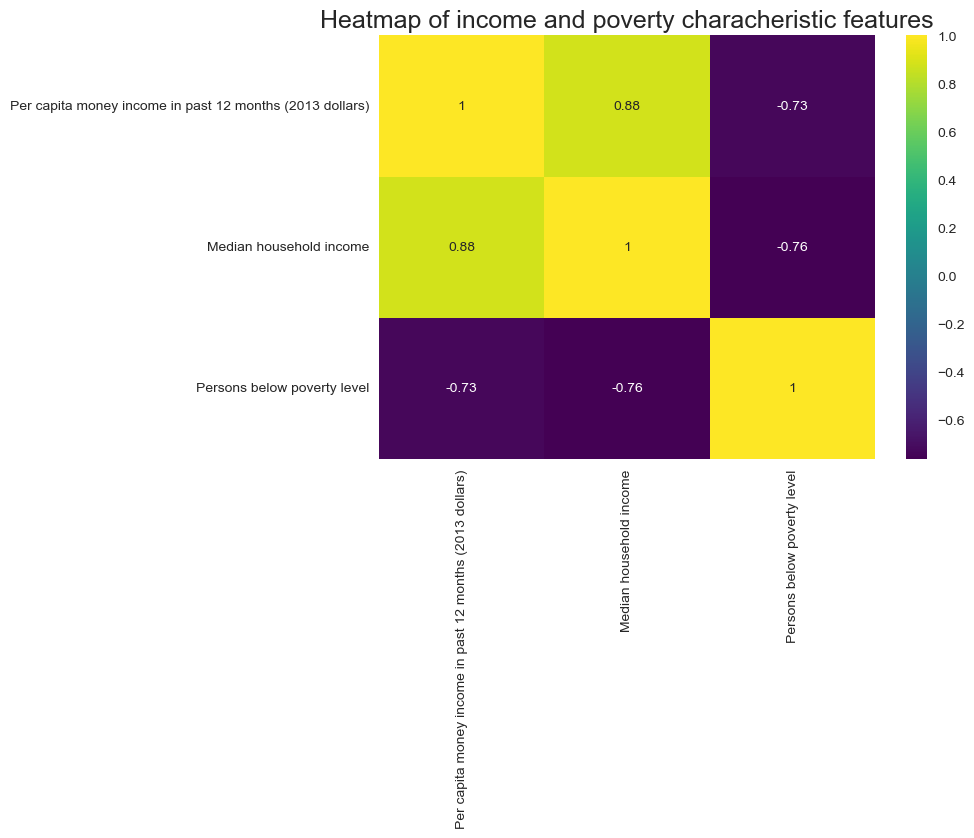

In [56]:
# heatmap of the columns
htmp = sns.heatmap(county_facts[facts_type["Income_poverty"]].corr(), 
                   cmap="viridis", annot=True)
labels = [label[:label.find(",")]
          for label in county_dictionary.loc[facts_type["Income_poverty"]]]
htmp.set_xticklabels(labels, rotation=90)
htmp.set_yticklabels(labels, rotation=0)
plt.title("Heatmap of income and poverty characheristic features",
          fontsize=18);

We see that all the columns in the Income_poverty type are strongly correlated. Let's also reduce these columns:

In [57]:
new_columns_county = reduce_dimensions(df=county_facts,
                                       columns=facts_type["Income_poverty"])

Principal Component 1 Loadings:
Per capita money income in past 12 months (2013 dollars), 2009-2013: 0.5851714442487866
Median household income, 2009-2013: 0.5914900554219138
Persons below poverty level, percent, 2009-2013: -0.5547196545758681

Original Data Shape: (2965, 3)
Reduced Data Shape (PCA): (2965, 1)
Number of Components Selected: 1


Drop the reduced columns and add a new one:

In [58]:
county_facts = county_facts.drop(columns=facts_type["Income_poverty"])
county_facts["income_level"] = new_columns_county

In [59]:
facts_type["Income_poverty"] = ["income_level"]
facts_type["Income_poverty"]

['income_level']

#### Economy:

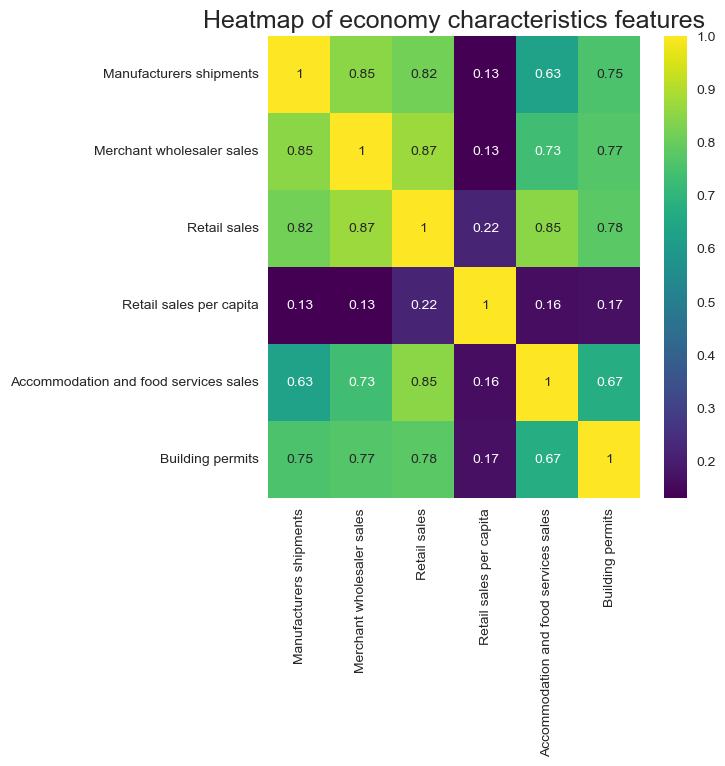

In [60]:
economy = facts_type["Economy"]
fig = plt.figure(figsize=(6, 6))
business_facts_corr = county_facts[economy].corr()
highest_corr_indeces = (business_facts_corr
                       .index)
htmp = sns.heatmap(county_facts[highest_corr_indeces].corr(),
                   cmap="viridis", annot=True)
labels = [label[:label.find(",")] 
          for label in county_dictionary.loc[highest_corr_indeces]]
htmp.set_xticklabels(labels, rotation=90)
htmp.set_yticklabels(labels, rotation=0);
plt.title("Heatmap of economy characteristics features",
         fontsize=18);

All the features, except "Retail sales per capita" are strongly correlated. Let's reduce them

In [61]:
county_dictionary.loc[facts_type["Economy"]]

column_name
MAN450207               Manufacturers shipments, 2007 ($1,000)
WTN220207             Merchant wholesaler sales, 2007 ($1,000)
RTN130207                          Retail sales, 2007 ($1,000)
RTN131207                        Retail sales per capita, 2007
AFN120207    Accommodation and food services sales, 2007 ($...
BPS030214                               Building permits, 2014
Name: description, dtype: object

In [62]:
# extract correlated columns
columns_to_reduce = [
    column for column in facts_type["Economy"] if column != "RTN131207"]

# apply the dimensionality reduction function
new_columns_county = reduce_dimensions(df=county_facts, 
                                       columns=columns_to_reduce)

Principal Component 1 Loadings:
Manufacturers shipments, 2007 ($1,000): 0.4435333625934896
Merchant wholesaler sales, 2007 ($1,000): 0.46238798255369096
Retail sales, 2007 ($1,000): 0.47173069498938014
Accommodation and food services sales, 2007 ($1,000): 0.4234762817158758
Building permits, 2014: 0.4331437406743547

Principal Component 2 Loadings:
Manufacturers shipments, 2007 ($1,000): -0.5013573108113724
Merchant wholesaler sales, 2007 ($1,000): -0.1699030436381013
Retail sales, 2007 ($1,000): 0.20177430113335887
Accommodation and food services sales, 2007 ($1,000): 0.774295540108774
Building permits, 2014: -0.28200594076775204

Original Data Shape: (2965, 5)
Reduced Data Shape (PCA): (2965, 2)
Number of Components Selected: 2


In [63]:
first_column = "economic_activity"
second_column = "hospitality_services"
facts_type["Economy"] = [first_column, second_column, "RTN131207"]
county_facts = county_facts.drop(columns=columns_to_reduce)
county_facts[facts_type["Economy"][:-1]] = new_columns_county

#### Geography:

In [64]:
geography = facts_type["Geography"]
display(pd.concat([state_facts[geography].describe(),
                   county_facts[geography].describe()],
                  keys=["State", "County"]))

Land area in square miles, 2010  \
State  count                            51.00   
       mean                          69253.05   
       std                           85526.08   
       min                              61.05   
       25%                           33334.51   
       50%                           53624.76   
       75%                           80692.73   
       max                          570640.95   
County count                          2965.00   
       mean                           1124.50   
       std                            3697.18   
       min                               2.00   
       25%                             429.49   
       50%                             608.84   
       75%                             916.31   
       max                          145504.79   

              Population per square mile, 2010  
State  count                             51.00  
       mean                             384.41  
       std                             1377.37  
       min                                1.20  
       25%                               45.80  
       50%                              101.20  
       75%                              221.45  
       max                             9856.60  
County count                           2965.00  
       mean                             270.22  
       std                             1765.31  
       min                                0.00  
       25%                               19.80  
       50%                               48.10  
       75%                              126.20  
       max                            69467.50

Modify the Population per square mile column but dividing the population column by the land ares

In [65]:
county_facts["POP060210"] = (county_facts["PST045214"] 
                             / county_facts["LND110210"])

#### We have finished exploring the demographic columns. Therefore, let's move on to the voting analysis:

We will analyze the following things:
  * number of votes for a party: 
       * determining the leading party by vote count in each county.
       * identifying regions where each party garnered significant number of voters.
       * pinpointing states where our party secured the highest number of voters.
       * identifying states where the Republican party garnered the most voters.
       * analyzing which candidate obtained the highest number of votes.
   
    Addressing these questions aids in identifying areas where our party's popularity needs enhancement. Additionally, recognizing regions where Republicans excelled in their primaries highlights areas requiring attention.
  
  * Winning Regions:
      * Identify the areas where each candidate won within their respective parties.          
      * Determine the states where Trump enjoys the strongest support and where Clinton had the weakest performance. 
    
   * Compare demographic charachteristics:
      * Examine the main candidates of each party
      * Compare the demographic characteristics of counties where each candidate won.
      * Identify differences between the candidates, particularly focusing on Trump's supporters and areas where Clinton lost ground.
      
     Identifying the regions where Trump garnered the most support and where Clinton faced significant setbacks can guide us towards areas requiring heightened attention.


#### Which party have gathered more votes?

In [67]:
# group by party and count number of votes for each
party_votes = primary_results.groupby("party")["votes"].sum()
party_votes

party
Democrat      27787095
Republican    29164706
Name: votes, dtype: int64

Our party is currently trailing in voter participation. By boosting our mobilization efforts and increasing enthusiasm among our supporters, we have the opportunity to improve our chances of winning in the upcoming elections.

#### Who had gathered more votes in each county?

Upload the .shp file in order to plot a map data. 

In [68]:
usa_counties = gpd.read_file("data/county_shapefiles/cb_2014_us_county_5m.shp")
usa_counties.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,01,059,00161555,0500000US01059,01059,Franklin,06,1641580723,32904833,"POLYGON Z ((-88.16591 34.38093 0.00000, -88.16..."
1,13,111,00351094,0500000US13111,13111,Fannin,06,1002370118,13560697,"POLYGON Z ((-84.62148 34.98833 0.00000, -84.50..."
2,19,109,00465243,0500000US19109,19109,Kossuth,06,2519332669,4154722,"POLYGON Z ((-94.44314 43.25501 0.00000, -94.44..."
3,40,115,01101845,0500000US40115,40115,Ottawa,06,1219467406,35708892,"POLYGON Z ((-95.03412 36.99423 0.00000, -95.00..."
4,42,115,01213688,0500000US42115,42115,Susquehanna,06,2132881515,22356541,"POLYGON Z ((-76.13120 41.99895 0.00000, -76.12..."


Modify the dataframe with the map data

In [69]:
usa_counties["STATEFP"] = usa_counties["STATEFP"].astype("int")
usa_counties["COUNTYFP"] = usa_counties["COUNTYFP"].astype("int")
usa_counties["fips"] = (usa_counties["STATEFP"] * 1000
                        + usa_counties["COUNTYFP"])
usa_counties["NAME"] = usa_counties["NAME"].str.lower().str.strip()

Prepare a table displaying the count of votes for each party in each county. When data is available only at the state or congressional district level, consolidate the values at the state level.

In [70]:
turnout_county = (primary_results
                 .groupby(["state", "county", "fips", "party"])["votes"]
                 .sum().unstack().fillna(0).reset_index(level="fips"))
for state in ["Wyoming", "Maine", "Colorado"]:
    # state.lower() is used because in the "county"
    # columns the values are lowercase
    
    # sum the values for all counties
    state_results = turnout_county.loc[state, "Democrat"].sum()
    turnout_county.loc[(state, state.lower()), "Democrat"] = state_results
    
    # keep only the state results
    turnout_county.loc[state] = turnout_county[
        turnout_county.index==(state, state.lower())]

turnout_county = turnout_county.dropna()
determine_winner = (lambda row: 
                    "Republican" if row["Republican"] > row["Democrat"]
                    else "Democrat")
turnout_county["winner"] = turnout_county.apply(determine_winner,
                                               axis=1)
turnout_county.head()

party              fips  Democrat  Republican      winner
state   county                                           
Alabama autauga 1001.00   2931.00    11839.00  Republican
        baldwin 1003.00   7984.00    49100.00  Republican
        barbour 1005.00   2789.00     3357.00  Republican
        bibb    1007.00   1188.00     3891.00  Republican
        blount  1009.00    959.00    14791.00  Republican

Modify the table with the map data, merge it with the "turnout_county" table and plot the data

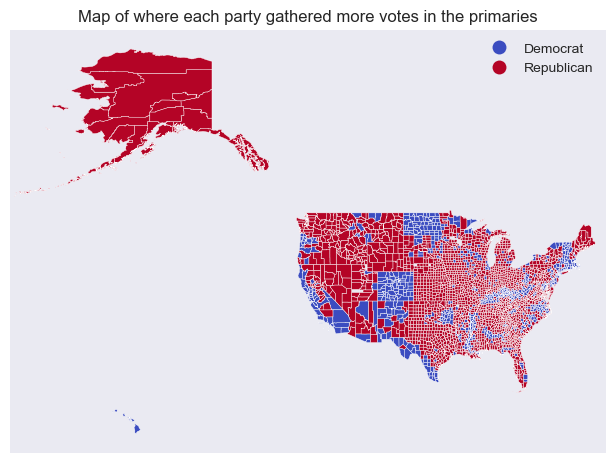

In [71]:
# copy the dataframe with the map data
usa_counties_parties = usa_counties.copy()

# modify the "fips" column for counties where
# the results are by the state leve
usa_counties_parties.loc[usa_counties_parties["STATEFP"]==20, "fips"] = 20000
usa_counties_parties.loc[usa_counties_parties["STATEFP"]==2, "fips"] = 2000
usa_counties_parties.loc[usa_counties_parties["STATEFP"]==38, "fips"] = 38000
usa_counties_parties.loc[usa_counties_parties["STATEFP"]==56, "fips"] = 56000
usa_counties_parties.loc[usa_counties_parties["STATEFP"]==8, "fips"] = 8000
usa_counties_parties.loc[usa_counties_parties["STATEFP"]==23, "fips"] = 23000


# merge the table with the data about winnner in each county
usa_counties_parties = pd.merge(usa_counties_parties,
                                turnout_county,
                                left_on="fips",
                                right_on="fips",how="right")

# plot the data
usa_counties_parties.plot(column="winner", cmap="coolwarm", legend=True)
plt.xlim(-180, -65)
plt.xticks([])
plt.yticks([]);
plt.title("Map of where each party gathered more votes in the primaries");

Upon reviewing the map data, it's evident that Republicans have garnered more votes across the majority of the country. This suggests a need for us to prioritize efforts to enhance our party's popularity in numerous regions. Doing so can enhance support for our party moving forward.

#### What are the states with Republican highest number of voters compared to ours?

Here is the table with number of votes for each party in each state with the "winner" column indicating the party which garnered more votes

In [72]:
# group by state and party and count voter turnout for each state and party
turnout_state = (primary_results
                 .groupby(["state", "party"])["votes"]
                 .sum().unstack())

# merge with state_facts table to get "fips" value for the county
turnout_state = pd.merge(
    turnout_state, 
    state_facts.reset_index()[["area_name", 'fips']],
    left_on="state", right_on="area_name", how="right")
turnout_state["winner"] = turnout_state.apply(determine_winner, axis=1)
turnout_state.head()

,Democrat,Republican,area_name,fips,winner
0,386327.00,837632.00,Alabama,1000,Republican
1,539.00,21930.00,Alaska,2000,Republican
2,399097.00,435103.00,Arizona,4000,Republican
3,209448.00,396523.00,Arkansas,5000,Republican
4,3442623.00,1495574.00,California,6000,Democrat


Function which computes the ratio, indicating the relative number of votes for the winning party compared to its opponent in a given election.

In [73]:
def calc_turnout_ratio(row: pd.Series) -> int:
    """
    Parameters: 
        - row(Series)
    Return:
        - int
    """
    if row["winner"] == "Democrat":
        return row["Democrat"] / row["Republican"]
    else:
        return row["Republican"] / row["Democrat"]

Add "turnout_ratio" columns:

In [74]:
turnout_state["turnout_ratio"] = turnout_state.apply(calc_turnout_ratio,
                                                     axis=1)

Show the states where Republicans got 2 times more votes than us

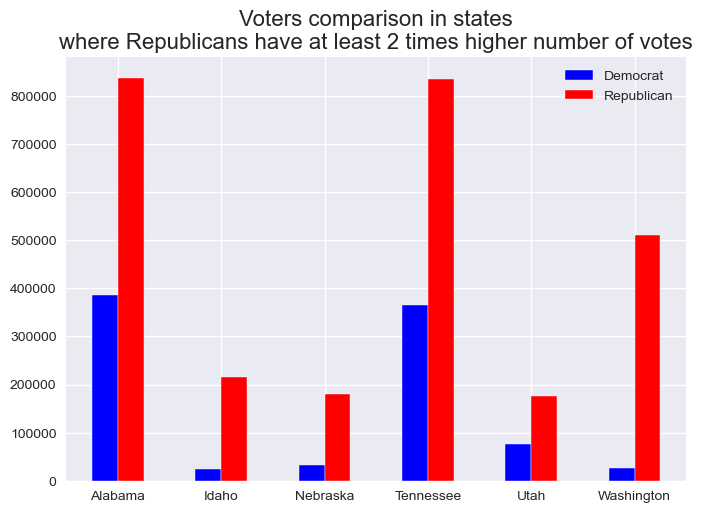

In [75]:
# extract states where the Republicans got 2 times more votes
rep_advantage = ((turnout_state["turnout_ratio"] > 2)
                 &(turnout_state["winner"] == "Republican")
                 &(turnout_state["Republican"] > 100000))
rep_states = turnout_state[rep_advantage]
rep_states = (rep_states[["area_name", "Democrat", "Republican"]]
              .set_index('area_name')) 
# plot the barplot with the specified colors
with sns.color_palette(["blue", "red"]):
    rep_states.plot(kind="bar")

plt.title("Voters comparison in states\n"
          "where Republicans have at least 2 times higher number of votes",
          fontsize=16)
plt.xticks(rotation=0)
plt.xlabel("");

These are the states where Republicans gathered way more voters than we did. We should especially focus on imporving our popularity here

#### What are the states where we had more voters?

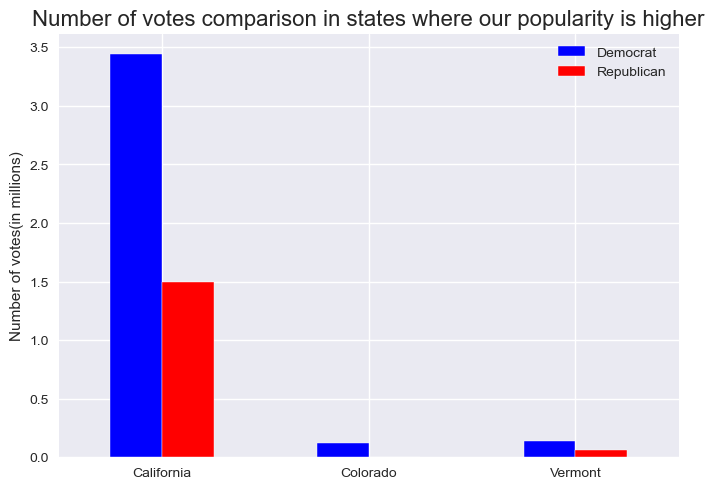

In [76]:
# extract the states where number of our voters
# is 2 times bigger 
dem_advantage = ((turnout_state["winner"] == "Democrat")
                 & (turnout_state["turnout_ratio"] > 2)
                 & (turnout_state["Democrat"] > 100000))
dem_states = turnout_state[dem_advantage]
dem_states = (dem_states[["area_name", "Democrat", "Republican"]]
              .set_index('area_name'))

with sns.color_palette(["blue", "red"]):
    dem_states.plot(kind="bar")

plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: x/1e6))
plt.title("Number of votes comparison in states where"
          " our popularity is higher", fontsize=16)
plt.ylabel("Number of votes(in millions)")
plt.xticks(rotation=0)
plt.xlabel("");

These are the states where our popularity is higher

Alabama, Nebraska, South Carolina, Washington, Tennessee, Utah, Idaho are the states we have to look at to increase our popularity.

#### By candidate who has more votes?

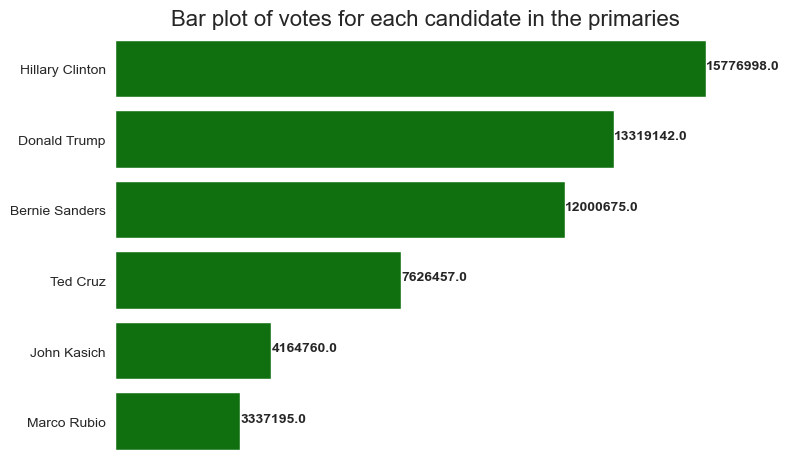

In [77]:
# sum the votes for each candidate and extract most popular ones
votes_cand = (primary_results.groupby("candidate")["votes"]
              .sum()
              .sort_values(ascending=False).head(6))

with plt.style.context('seaborn-white'):
    sns.barplot(y=votes_cand.index, x=votes_cand.values, color="green")

plt.title("Bar plot of votes for each candidate in the primaries",
          fontsize=16)
customize_bar("h", plt.gca())
plt.ylabel("");

While the Republican turnout exceeded ours, Hillary Clinton garnered the highest number of votes

Divide primaries into two parties:

In [78]:
republicans = primary_results["party"] == "Republican"
democrats = primary_results["party"] == "Democrat"
republican_primaries = primary_results[republicans]
democrat_primaries = primary_results[democrats]

# drop "party" column as they are not necessary in these tables
republican_primaries = republican_primaries.drop(columns="party")
democrat_primaries = democrat_primaries.drop(columns="party")

#### Who are the winners in each party?

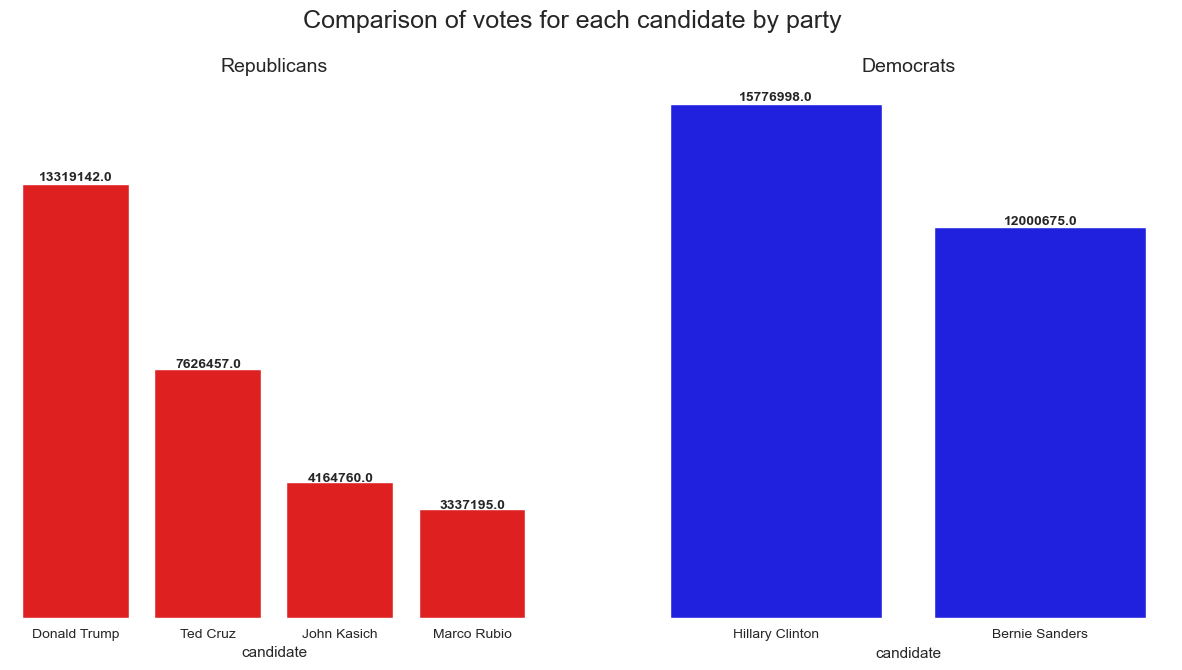

In [79]:
rep_cand_votes = (republican_primaries.groupby("candidate")["votes"]
                  .sum().sort_values(ascending=False).head(4))
dem_cand_votes = (democrat_primaries.groupby("candidate")["votes"]
                  .sum().sort_values(ascending=False).head(2))

with plt.style.context('seaborn-white'):
    fig, ax = plt.subplots(1, 2, figsize=(15, 7), sharey=True)
sns.barplot(x=rep_cand_votes.index, y=rep_cand_votes.values,
            ax=ax[0], color="red")
sns.barplot(x=dem_cand_votes.index, y=dem_cand_votes.values, 
            ax=ax[1], color="blue")

ax[0].set_title("Republicans", fontsize=14)
ax[1].set_title("Democrats", fontsize=14)
plt.suptitle("Comparison of votes for each candidate by party", 
             fontsize=18)
customize_bar("v", ax[0], ax[1])

We've observed that Republicans have four main candidates: Donald Trump, Ted Cruz, John Kasich, and Marco Rubio, while Democrats have two prominent candidates: Hillary Clinton and Bernie Sanders. Let's focus solely on the voting results for these candidates in our tables.

In [80]:
# extract voting results only for the specified candidates
rep_candidates = ["Donald Trump", "Ted Cruz",
                  "John Kasich", "Marco Rubio"]
dem_candidates = ["Hillary Clinton", "Bernie Sanders"]
republican_primaries = republican_primaries[
    republican_primaries["candidate"].isin(rep_candidates)]

democrat_primaries = democrat_primaries[
    democrat_primaries["candidate"].isin(dem_candidates)]

Function, which adds the winner column to the parties results indicating the winner in each county.

In [81]:
def add_winner(party_primaries: pd.DataFrame) -> pd.DataFrame:
    """
    Function which takes the primary results of a party
    and adds the "winner" column with the name of candidates
    who got more votes in a county. Then keep only rows with
    the winning candidate.
    Parameters:
        - party_primaries(DataFrame): primary results for a party
    Return:
        - party_primaries(DataFrame): the modified table
    """
    # find winner in each county
    get_winner = (lambda group: 
                  group.loc[group["fraction_votes"].idxmax()]["candidate"])
    county_winner = party_primaries.groupby("fips").apply(get_winner)
    county_winner.name="winner"
    
    # merge the primaries with the county_winner Series
    party_primaries = pd.merge(party_primaries,
                               county_winner,
                               left_on="fips",
                               right_index=True,
                               how="left")
    
    # keep rows with the winner data
    party_primaries = party_primaries[
        party_primaries["candidate"] == party_primaries["winner"]
    ]
    return party_primaries


In [82]:
republican_primaries = add_winner(republican_primaries)
democrat_primaries = add_winner(democrat_primaries)

#### What are the areas of each candidate's wins in each party?

Democrats:

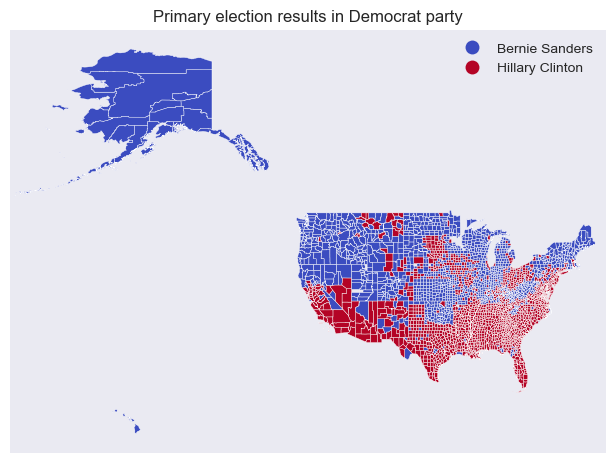

In [83]:
usa_counties.loc[usa_counties["STATEFP"]==20, "fips"] = 20000
usa_counties.loc[usa_counties["STATEFP"]==2, "fips"] = 2000
usa_counties.loc[usa_counties["STATEFP"]==38, "fips"] = 38000


usa_counties = pd.merge(usa_counties,
                        democrat_primaries[["fips", "winner"]], 
                        left_on="fips", 
                        right_on="fips",how="right").rename(
    columns={"winner" :"dem_winner"})

usa_counties.plot(column="dem_winner", cmap="coolwarm", legend=True)
plt.xticks([])
plt.yticks([])
plt.title("Primary election results in Democrat party")
plt.xlim(-180, -65);

Republicans

(-180.0, -65.0)

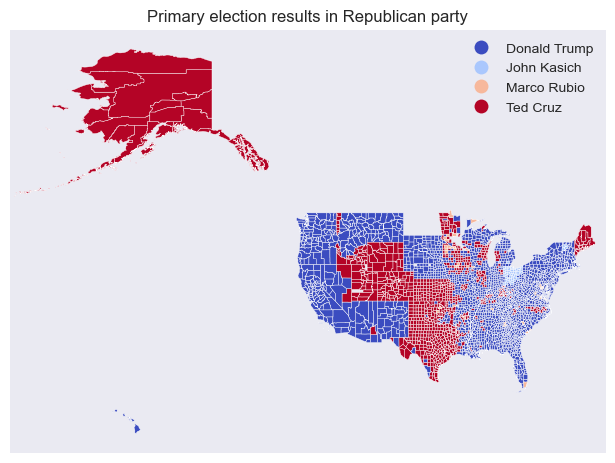

In [84]:
usa_counties.loc[usa_counties["STATEFP"]==56, "fips"] = 56000
usa_counties.loc[usa_counties["STATEFP"]==8, "fips"] = 8000
usa_counties.loc[usa_counties["STATEFP"]==23, "fips"] = 23000
usa_counties = pd.merge(usa_counties,
                        republican_primaries[["fips", "winner"]], 
                        left_on="fips", 
                        right_on="fips",how="right").rename(
    columns={"winner" :"rep_winner"})

usa_counties.plot(column="rep_winner", cmap="coolwarm", legend=True)
plt.xticks([])
plt.yticks([])
plt.title("Primary election results in Republican party")
plt.xlim(-180, -65)

When looking at the map results of primaries for both parties, we have come up with the following conlusions:
 * Among both parties, there are two main leaders:
     * Republicans: Trump and Cruz
     * Democrats: Clinton and Sanders
 * The democrats results are very close. Around half of the country is won by Sanders and another half by Clinton. Clinton won by a small margin. It is clearly visible that Clinton's popularity is in the South of the country while Sanders' is in the North.
 * In the republican party, Trump won more convincingly. We can see that he lost in Texas, Wyoming, Alaska, Colorado areas. Though, in majority of states, he wins most of the counties. One of the reasons Cruz is so popular in Texas could be due to the fact that he has been a senator of the USA from Texas 

Now we will work with states. Let's do the following:
 * find the states which support Trump the most
 * find the states where Sanders defeated Clinton with the biggest margin 
 * the intersection of these states are states which we should pay attention to.

Let's try to highlight states where Trump is most supported

In [85]:
# create a table with the number of counties won
# in each state for each candidate

# county counties for each candidate
state_counties_won = (republican_primaries
                      .groupby(['state', "winner"])
                      ["county"].count().reset_index())
# apply pivot_table to make candidate's names columns
state_counties_won = (state_counties_won
                      .pivot_table(values="county", 
                                   index="state",
                                   columns="winner").fillna(0))

# extract states where Trump won all the counties
state_counties_won.apply(lambda row: 
                         row if row.iloc[-3:].sum()==0 else None,
                         axis=1).dropna()

winner,Donald Trump,John Kasich,Marco Rubio,Ted Cruz
state,,,,
Alabama,67.00,0.00,0.00,0.00
California,58.00,0.00,0.00,0.00
Connecticut,8.00,0.00,0.00,0.00
Delaware,3.00,0.00,0.00,0.00
Hawaii,4.00,0.00,0.00,0.00
Maryland,24.00,0.00,0.00,0.00
Massachusetts,14.00,0.00,0.00,0.00
Montana,56.00,0.00,0.00,0.00
Nebraska,91.00,0.00,0.00,0.00


These are the states where Trump won all counties. We become more confident that Trump won the primaries very convincingly

In [86]:
# do the same for Democrats
state_counties_won = (democrat_primaries
                      .groupby(['state', "winner"])
                      ["county"].count().reset_index())
state_counties_won = (state_counties_won
                      .pivot_table(values="county", 
                                   index="state", 
                                   columns="winner").fillna(0))

state_sanders_won = (state_counties_won[
    state_counties_won["Hillary Clinton"] == 0])
state_sanders_won

winner,Bernie Sanders,Hillary Clinton
state,,
Alaska,1.00,0.00
Hawaii,4.00,0.00
Kansas,1.00,0.00
New Hampshire,10.00,0.00
North Dakota,1.00,0.00
Rhode Island,5.00,0.00
Utah,26.00,0.00
Vermont,14.00,0.00
Washington,39.00,0.00


These are the states where Clinton performed most poorly.

After analyzing Trump's and Sanders' most supporting states we can highlight some states states to focus on, where Clinton's support is awful:  West Virginia, Washington, Rhode Island.

Now, let's dig into counties and demographic charachteristics. How each candidate's supporters differ in each party?

Function which merges the party primaries data with the county_facts table:

In [87]:
def merge_facts_table(party: pd.DataFrame) -> pd.DataFrame:
    """
    Take the primaries for a party and merge it with the
    "county_facts" table to get the demographic charachteristics
    for each county.
    Parameters:
        - party(DataFrame): primary results in a party
    Return:
        - the merged table
    """
    return (pd.merge(county_facts,
                     party, 
                     left_index=True, right_on="fips", how="inner")
            .drop(columns=["state_abbreviation_x",
                           "state_abbreviation_y",
                           "area_name",
                           "candidate"]))

In [88]:
rep_facts = merge_facts_table(republican_primaries)
dem_facts = merge_facts_table(democrat_primaries)

Analyze population for winners

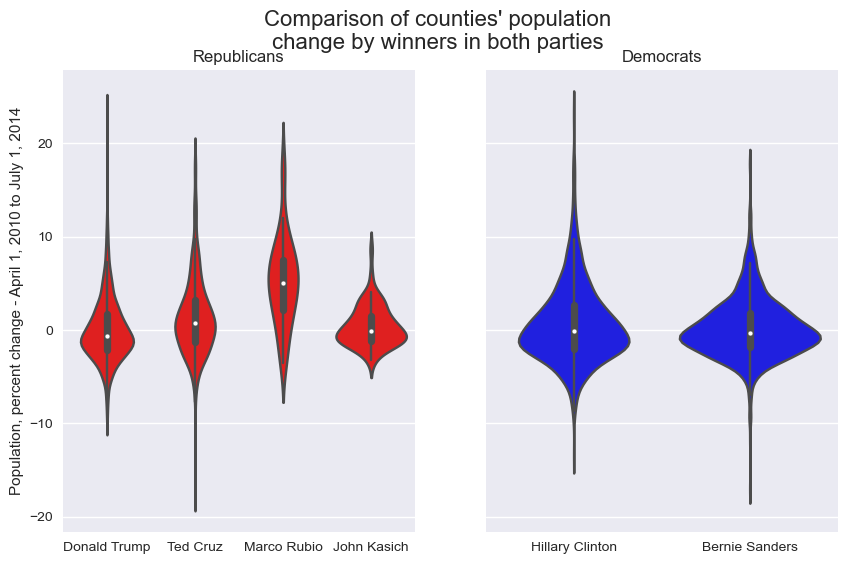

In [89]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=True)

pop_columns = facts_type["Population"]
sns.violinplot(x="winner", y=pop_columns[1], data=rep_facts, 
               ax=ax[0], color="red")
sns.violinplot(x="winner", y=pop_columns[1], 
               data=dem_facts, ax=ax[1], color="blue")
plt.suptitle("Comparison of counties' population\n"
             "change by winners in both parties", fontsize=16)

ax[0].set_title("Republicans")
ax[1].set_title("Democrats")
ax[0].set_ylabel(county_dictionary.loc[pop_columns[1]])
ax[1].set_ylabel("")
ax[0].set_xlabel("")
ax[1].set_xlabel("");

* Republicans:
    Trump's and Cruz's counties experience similar population percentage changes, while Marco Rubio distinguishes himself by winning on average in counties with higher population percentage changes. Cruz has support in counties with the lowest population change
* Democrats: Counties won by both Clinton and Sanders exhibit similar population changes. However, akin to Trump among Republicans, Clinton predominates in counties undergoing the most significant population shifts.

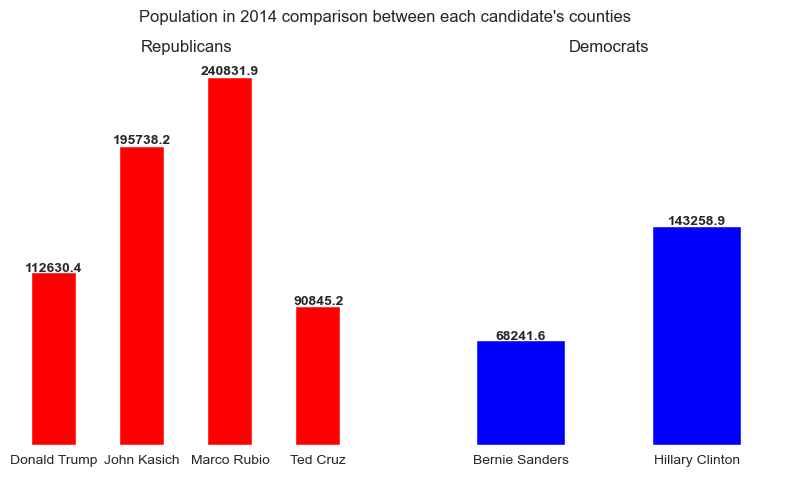

In [90]:
with plt.style.context('seaborn-white'):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
    rep_facts.groupby("winner")[pop_columns[0]].mean().plot(kind="bar",
                                                            ax=ax[0],
                                                           color="red")
    dem_facts.groupby("winner")[pop_columns[0]].mean().plot(kind="bar", 
                                                            ax=ax[1],
                                                           color="blue")
    
plt.suptitle("Population in 2014 comparison between each candidate's counties")
ax[0].set_title("Republicans")
ax[1].set_title("Democrats")
for axis in ax:
    axis.set_xlabel("")
    axis.tick_params(axis='x', rotation=0)
customize_bar("v", ax[0], ax[1])

* Republicans: Rubio's counties stand out as on average they have the highest population. Trump's and Cruz' counties on average are least populated
* Democrats: Clinton is supported in more populated counties than Sanders. The difference in average population is around 2 times.

Age columns:

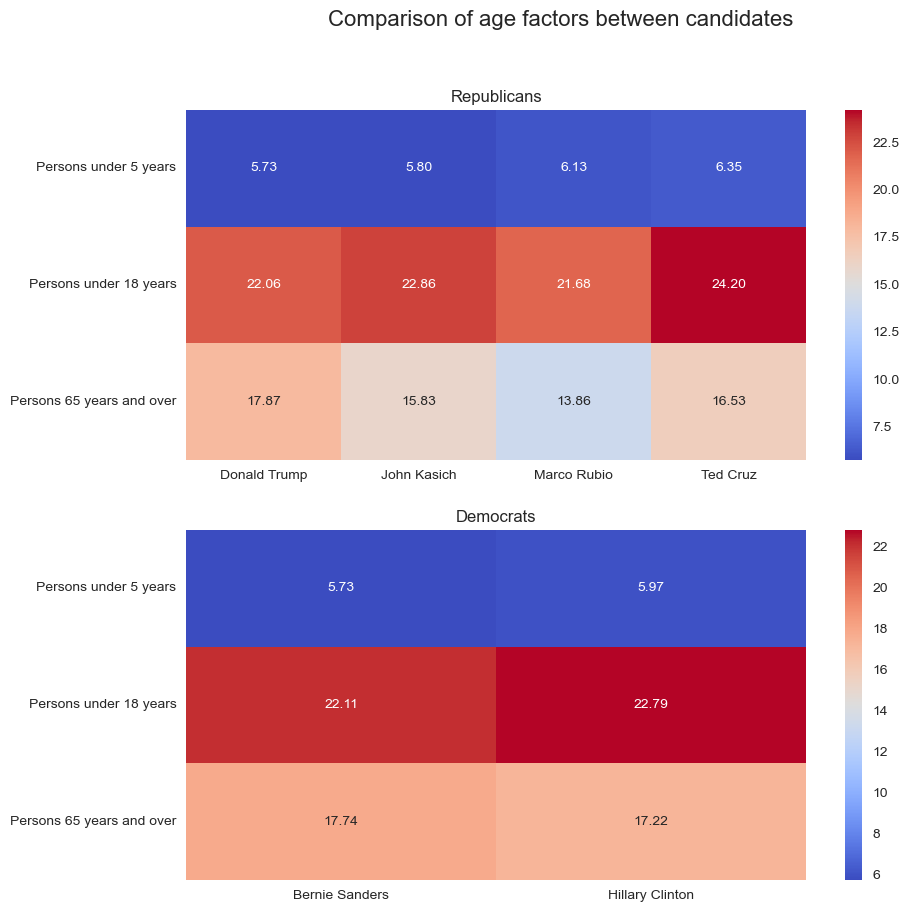

In [91]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharey=True)

# plot two heatmaps of mean age_sex features for both parties
for i, facts in enumerate([rep_facts, dem_facts]):
    mean_char = facts.groupby("winner")[age_sex[:-1]].mean()
    mean_char = mean_char.transpose()
    htmp = sns.heatmap(mean_char, cmap="coolwarm",
                       annot=True, fmt=".2f", 
                       ax=ax[i])
    yticklabels = [label[:label.find(",")]
                   for label in county_dictionary.loc[age_sex[:-1]]]
    htmp.set_yticklabels(yticklabels, rotation=0)
    htmp.set_xlabel("")
    

ax[0].set_title("Republicans")
ax[1].set_title("Democrats")
plt.suptitle("Comparison of age factors between candidates",
             fontsize=16);

* Republicans: Trump's counties exhibit the highest proportion of elderly residents, while Cruz's areas notably feature the highest percentage of individuals under 18. Conversely, Rubio's support regions show the lowest percentage of elderly residents.
* Democrats: there are no significant differences in age demographics between Clinton's and Sanders' counties

a


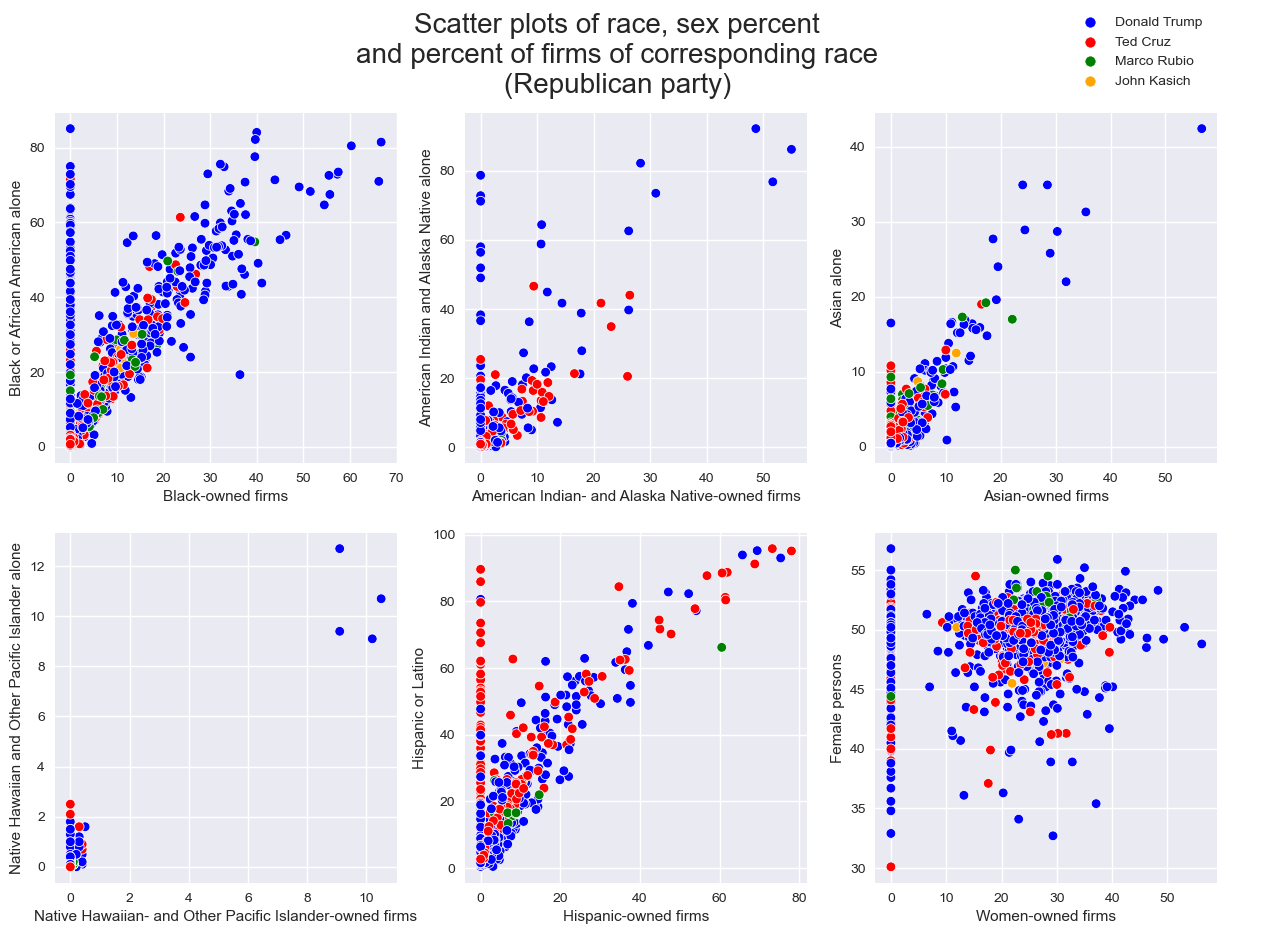

In [92]:
fig, plt, ax = scatterplot_race_firm(rep_facts, hue="winner")

# set the legend for all plots
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.84, 0.9))

# delete the legend for each plot
for row in ax:
    for axis in row:
        axis.legend().set_visible(False)

plt.suptitle("Scatter plots of race, sex percent\n"
            "and percent of firms of corresponding race\n"
            "(Republican party)", fontsize=20);

Trump garners support in counties with high percentages of all racial demographics except for Hispanic or Latino individuals. Cruz emerges victorious in the majority of counties with the highest percentages of Hispanic or Latino residents, particularly evident in Texas where he leads. However, it's noteworthy that Trump secures victories in some of these counties, which are characterized by a larger proportion of Hispanic-owned firms. Hence, while counties with high percentages of Hispanic or Latino populations tend to lean towards Cruz, the presence of a significant number of Hispanic-owned firms in some of these counties results in Trump winning in certain instances.

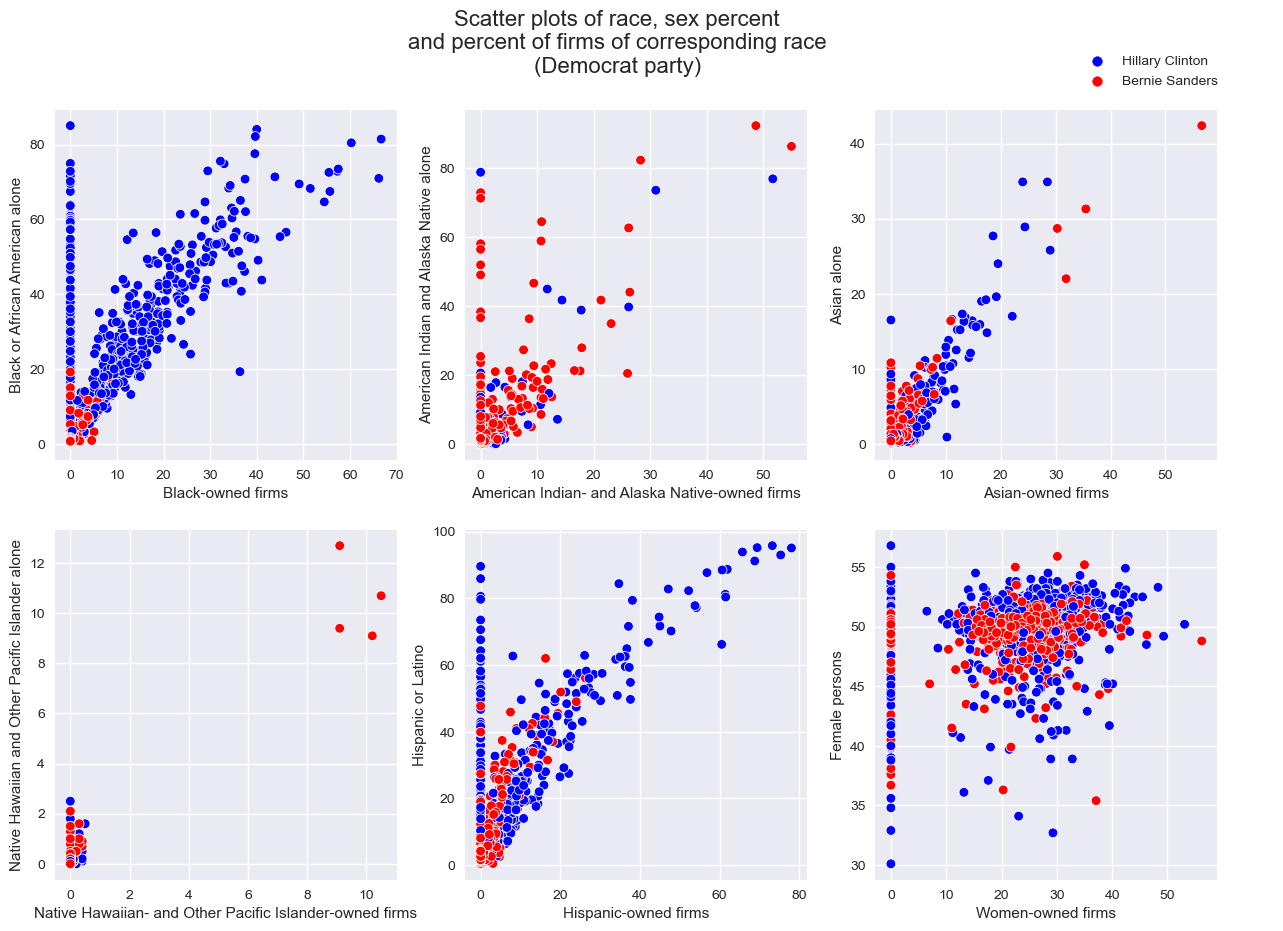

In [93]:
fig, plt, ax = scatterplot_race_firm(dem_facts, hue="winner")
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.84, 0.9))
for row in ax:
    for axis in row:
        axis.legend().set_visible(False)
plt.suptitle("Scatter plots of race, sex percent\n"
            "and percent of firms of corresponding race\n"
             "(Democrat party)", fontsize=16);

Clinton enjoys popularity in counties with significant percentages of Black, Asian, Hispanic, or Latino populations. Additionally, there is greater support for Clinton in counties with higher proportions of women. In areas with the highest percentages of American Indian and Alaska Native populations, Sanders receives more significant backing, while Native Hawaiians show stronger support for Sanders

#### Education:

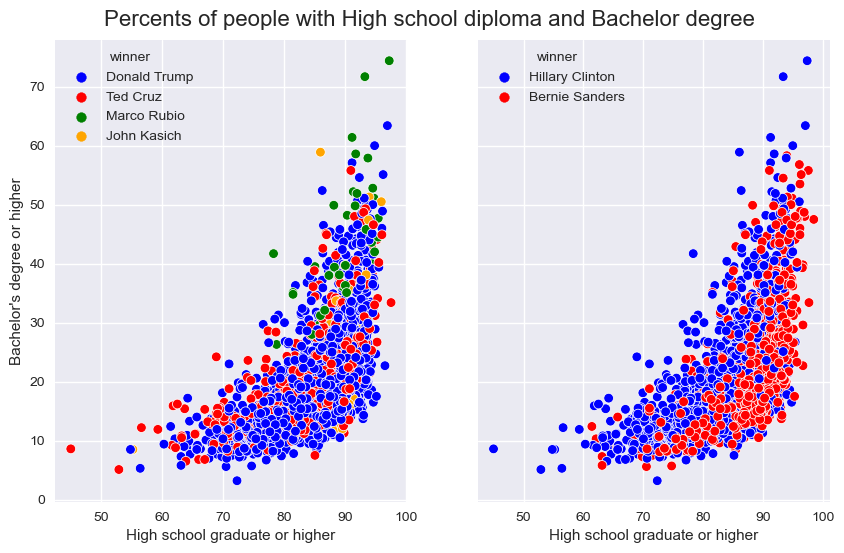

In [94]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
sns.scatterplot(x=facts_type["Education"][0], 
                y=facts_type["Education"][1], data=rep_facts,
                hue="winner", ax=ax[0], 
                palette=["blue", "red", "green", "orange"])

sns.scatterplot(x=facts_type["Education"][0], 
                y=facts_type["Education"][1], 
                data=dem_facts, hue="winner",
                palette=["blue", "red"], ax=ax[1])

xlabel = county_dictionary.loc[facts_type["Education"][0]]
xlabel = xlabel[:xlabel.find(",")]

for axis in ax:
    axis.set_xlabel(xlabel)
    
ylabel = county_dictionary.loc[facts_type["Education"][1]]
ylabel = ylabel[:ylabel.find(',')]
ax[0].set_ylabel(ylabel)

plt.suptitle("Percents of people with"
             " High school diploma and Bachelor degree", 
             y=0.93, fontsize=16);

* Republicans: Counties inclined towards Rubio are notably distinguished by elevated levels of educational attainment. In contrast, Trump's counties display a diverse spectrum, with some boasting high educational achievement while others exhibit lower levels.
* Democrats: Sanders secures more victories in counties where the proportion of individuals holding high school diplomas is the highest.

Income and poverty levels:

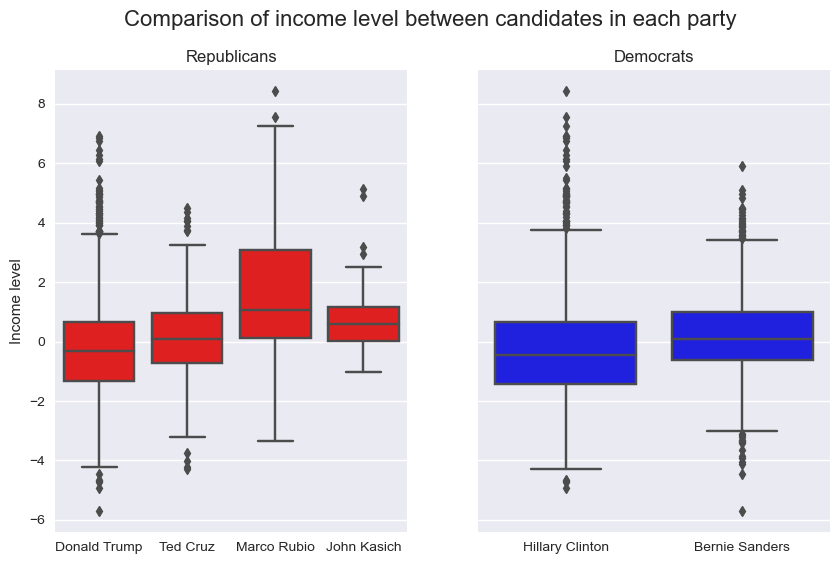

In [95]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
sns.boxplot(x="winner", y="income_level", data=rep_facts, 
            ax=ax[0], color="red")
sns.boxplot(x="winner", y="income_level", data=dem_facts, 
            ax=ax[1], color="blue")
plt.suptitle("Comparison of income level between candidates"
            " in each party", fontsize=16);
for axis in ax:
    axis.set_xlabel("")
    
ax[0].set_ylabel("Income level")
ax[0].set_title("Republicans")
ax[1].set_title("Democrats")
ax[1].set_ylabel("");

* Republicans: Trump prevails in the majority of counties with the lowest income levels, although he also secures victories in some affluent areas. Conversely, Rubio's counties stand out due to their superior income-poverty levels.
* Democrats: Clinton emerges victorious in the most affluent counties.

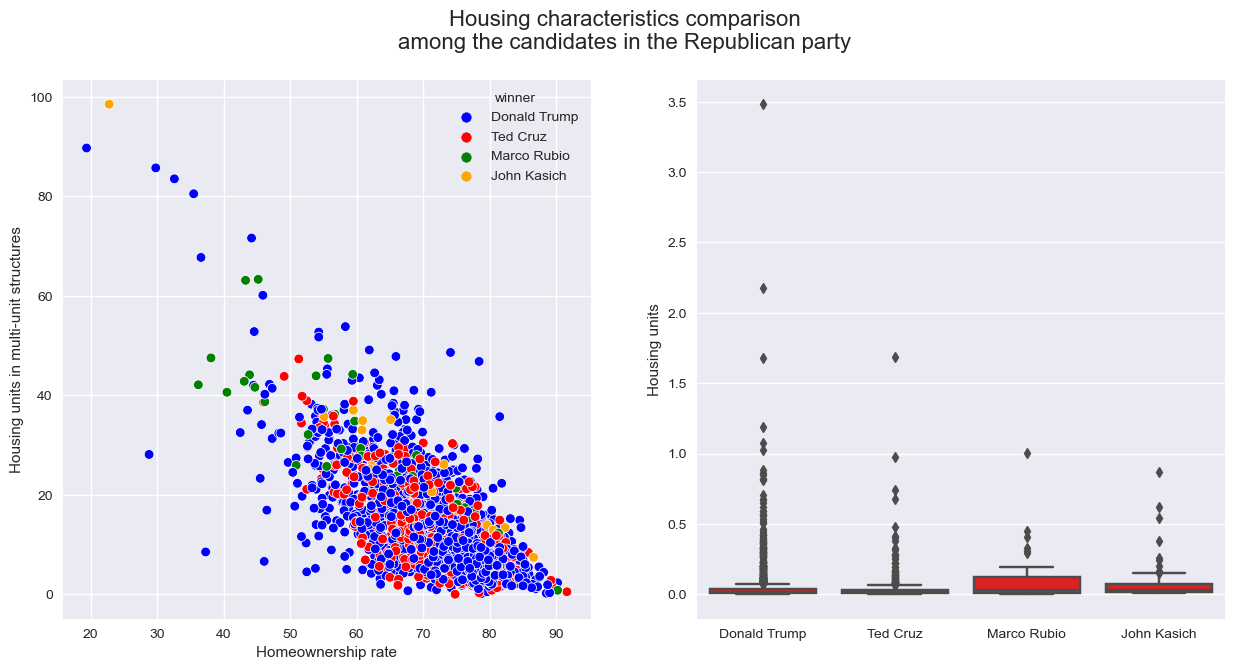

In [96]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
sns.scatterplot(x="HSG445213", y="HSG096213", data=rep_facts,
                hue="winner", ax=ax[0],
                palette=["blue", "red", "green", "orange"])
plt.suptitle("Housing characteristics comparison\n"
             "among the candidates in the Republican party",
            fontsize=16)
xlabel0 = county_dictionary.loc["HSG445213"]
xlabel0 = xlabel0[:xlabel0.find(",")]
ylabel0 = county_dictionary.loc["HSG096213"]
ylabel0 = ylabel0[:ylabel0.find(",")]
ax[0].set_xlabel(xlabel0)
ax[0].set_ylabel(ylabel0)


sns.boxplot(x="winner", y="HSG010214", data=rep_facts,
            ax=ax[1], color="red")
ax[1].set_xlabel("")
ylabel1 = county_dictionary.loc["HSG010214"]
ylabel1 = ylabel1[:ylabel1.find(",")]
ax[1].set_ylabel(ylabel1)
ax[1].yaxis.set_major_formatter(FuncFormatter(lambda x, _: x/1e6))


It's evident that Rubio garners significant backing from areas with a substantial proportion of housing units in multi-unit structures, which aligns with his strong support in populated counties and indicates that his counties are probably densely populated. Trump's support base has different values. He leads in counties boasting the highest rates of homeownership, while also taking over counties with the highest percent of housing units in multi-unit structures.

Let's take a look at the geographical features of the counties:

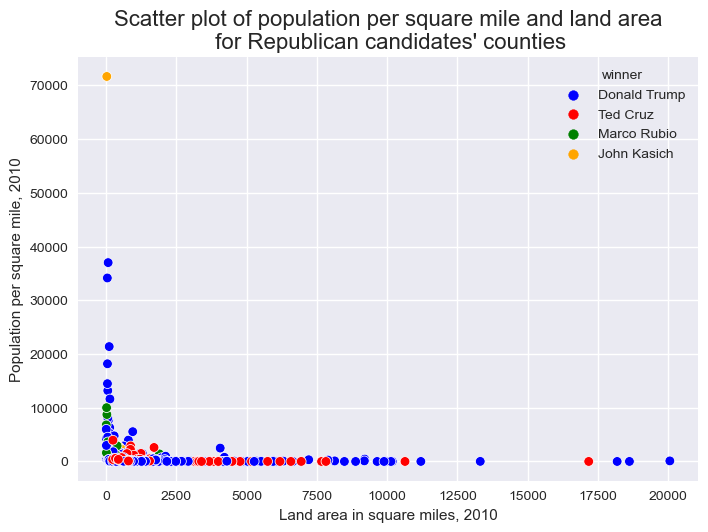

In [97]:
sns.scatterplot(x=facts_type["Geography"][0],
                y=facts_type["Geography"][1], 
                data=rep_facts, hue="winner",
                palette=["blue", "red", "green", "orange"])
xlabel = county_dictionary.loc[facts_type["Geography"][0]]
ylabel = county_dictionary.loc[facts_type["Geography"][1]]
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title("Scatter plot of population per square mile and land area"
         "\n for Republican candidates' counties", fontsize=16);

Just what we could expect: Rubio's counties are densely populated. Trump's widespread support can be attributed to his ability to attract voters from various demographic backgrounds and geographic regions. His appeal resonates with voters in densely populated urban areas as well as in less densely populated regions. This broad support base is reflected in his success across both types of areas, indicating his popularity among diverse segments of the population.

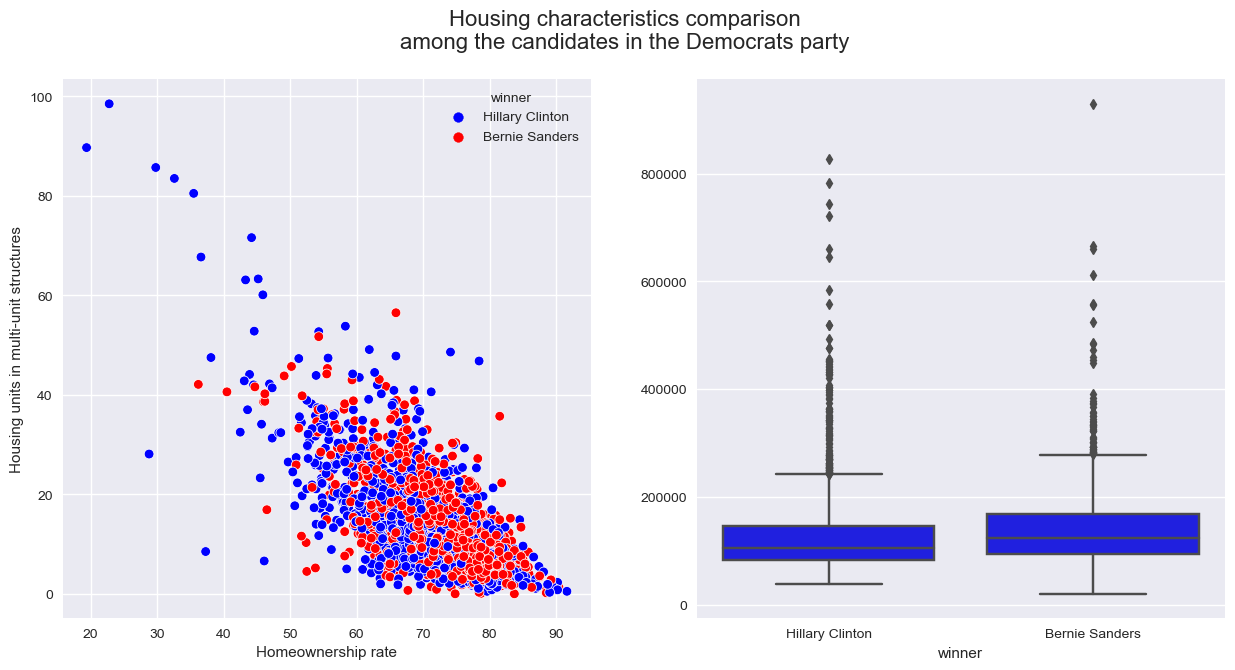

In [98]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
sns.scatterplot(x="HSG445213", y="HSG096213", data=dem_facts,
                hue="winner", ax=ax[0], palette=["blue", "red"])
sns.boxplot(x="winner", y="HSG495213", data=dem_facts,
            ax=ax[1], color="blue")

plt.suptitle("Housing characteristics comparison\n"
             "among the candidates in the Democrats party",
             fontsize=16)

xlabel0 = county_dictionary.loc["HSG445213"]
xlabel0 = xlabel0[:xlabel0.find(",")]
ylabel0 = county_dictionary.loc["HSG096213"]
ylabel0 = ylabel0[:ylabel0.find(",")]
ax[0].set_xlabel(xlabel0)
ax[1].set_ylabel("")
ax[0].set_ylabel(ylabel0);

Clinton emerges victorious in regions boasting the highest proportion of housing units within multi-unit structures. Such findings suggest that Clinton garners significant support in both urban and suburban environments. In Clinton's domains, there is a high demand for rental properties, potentially indicative of denser population centers. Conversely, Sanders' strongholds exhibit a higher rate of homeownership. 

Let's look into geographical features of the counties:

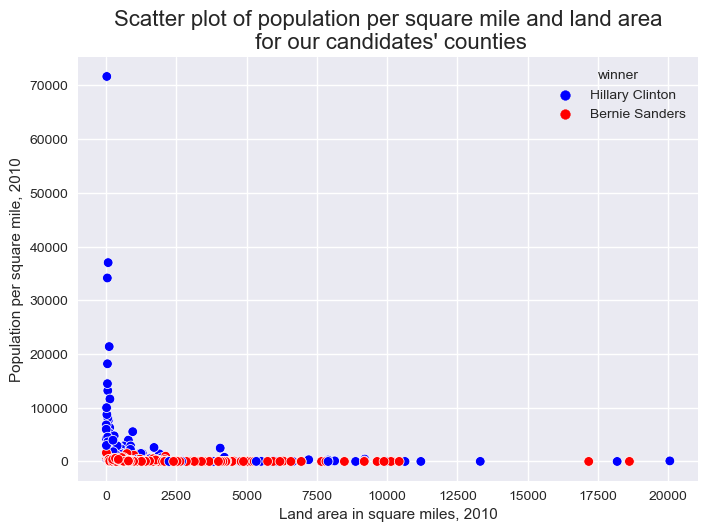

In [99]:
sns.scatterplot(x=facts_type["Geography"][0],
                y=facts_type["Geography"][1], 
                data=dem_facts, hue="winner", 
                palette=["blue", "red"])
xlabel = county_dictionary.loc[facts_type["Geography"][0]]
ylabel = county_dictionary.loc[facts_type["Geography"][1]]
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title("Scatter plot of population per square mile and land area"
         "\n for our candidates' counties", fontsize=16);

All the most dense populated counties are won by Hillary Clinton

Let's look at the comparison by some other demographic columns:

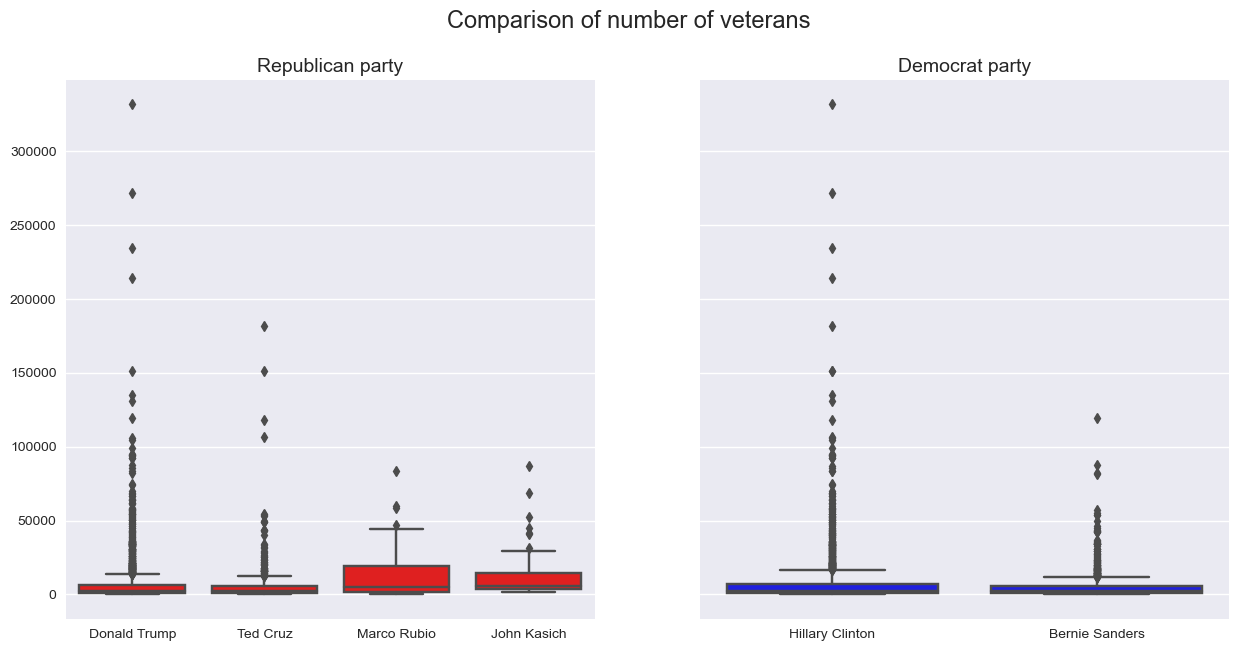

In [100]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7), sharey=True)

sns.boxplot(x="winner", y="VET605213", data=rep_facts, 
            ax=ax[0], color="red")
sns.boxplot(x="winner", y="VET605213", data=dem_facts, 
            ax=ax[1], color="blue")
plt.suptitle("Comparison of number of veterans", fontsize=17)
ax[0].set_xlabel("")
ax[1].set_xlabel("")
ax[0].set_ylabel("")
ax[1].set_ylabel("")
ax[0].set_title("Republican party", fontsize=14)
ax[1].set_title("Democrat party", fontsize=14);

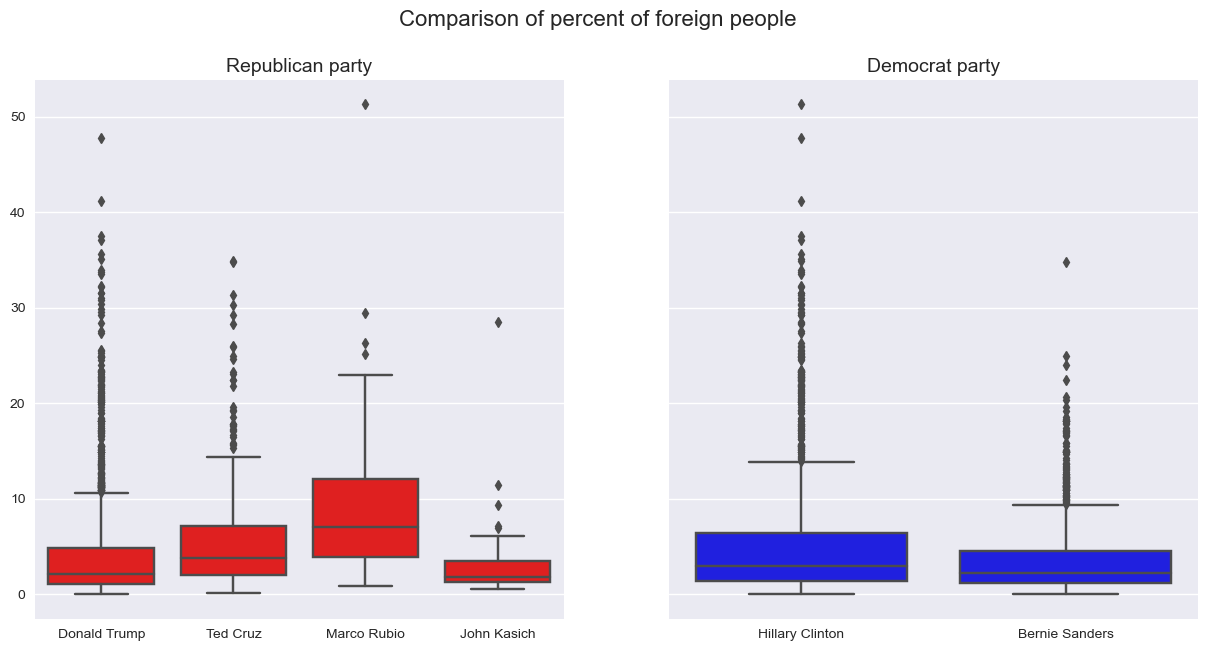

In [101]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7), sharey=True)
sns.boxplot(x="winner", y="POP645213", data=rep_facts, 
            ax=ax[0], color="red")
sns.boxplot(x="winner", y="POP645213", data=dem_facts, 
            ax=ax[1], color="blue")
plt.suptitle("Comparison of percent of foreign people", 
             fontsize=16)
ax[0].set_xlabel("")
ax[1].set_xlabel("")
ax[0].set_ylabel("")
ax[1].set_ylabel("")
ax[0].set_title("Republican party", fontsize=14)
ax[1].set_title("Democrat party", fontsize=14);

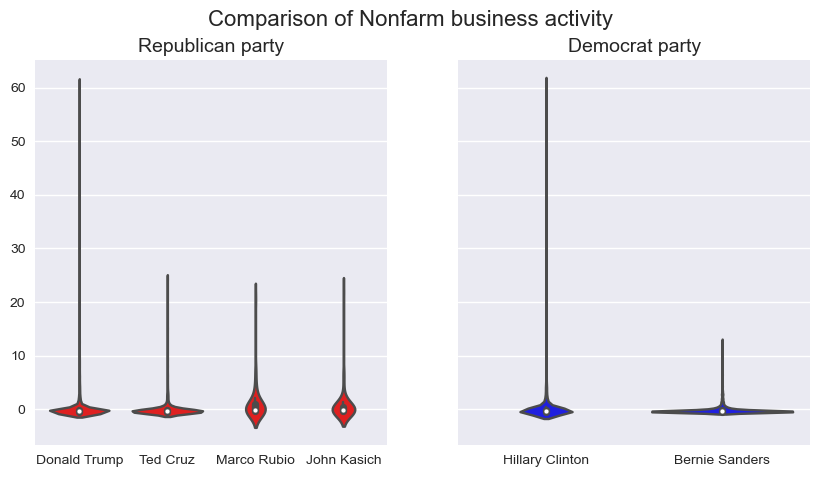

In [102]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
sns.violinplot(x="winner", y="nonfarm_business_activity",
               data=rep_facts, ax=ax[0], color="red")
sns.violinplot(x="winner", y="nonfarm_business_activity", 
               data=dem_facts, ax=ax[1], color="blue")
plt.suptitle("Comparison of Nonfarm business activity", 
             fontsize=16)
ax[0].set_xlabel("")
ax[1].set_xlabel("")
ax[0].set_ylabel("")
ax[1].set_ylabel("")
ax[0].set_title("Republican party", fontsize=14)
ax[1].set_title("Democrat party", fontsize=14);

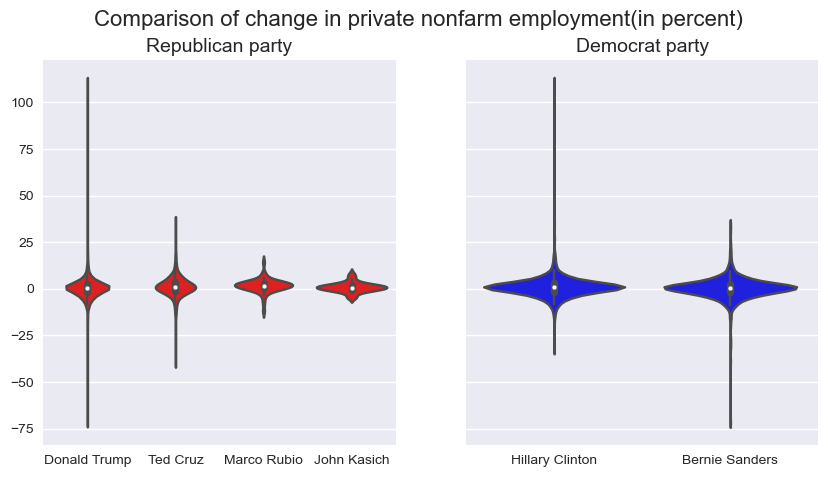

In [103]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
sns.violinplot(x="winner", y="BZA115213",
               data=rep_facts, ax=ax[0], color="red")
sns.violinplot(x="winner", y="BZA115213", 
               data=dem_facts, ax=ax[1], color="blue")
plt.suptitle("Comparison of change in private nonfarm employment(in percent)",
             fontsize=16)
ax[0].set_xlabel("")
ax[1].set_xlabel("")
ax[0].set_ylabel("")
ax[1].set_ylabel("")
ax[0].set_title("Republican party", fontsize=14)
ax[1].set_title("Democrat party", fontsize=14);

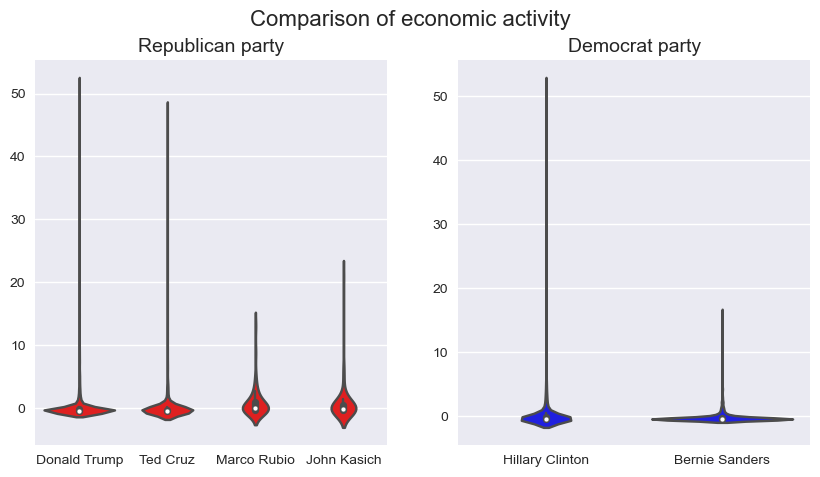

In [104]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.violinplot(x="winner", y="economic_activity",
               data=rep_facts, ax=ax[0], color="red")
sns.violinplot(x="winner", y="economic_activity", 
               data=dem_facts, ax=ax[1], color="blue")
plt.suptitle("Comparison of economic activity",
             fontsize=16)
ax[0].set_xlabel("")
ax[1].set_xlabel("")
ax[0].set_ylabel("")
ax[1].set_ylabel("")
ax[0].set_title("Republican party", fontsize=14)
ax[1].set_title("Democrat party", fontsize=14);

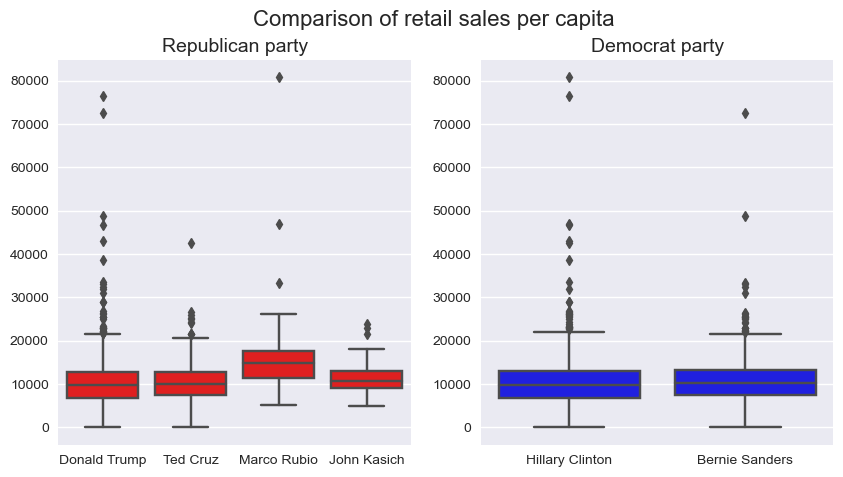

In [105]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.boxplot(x="winner", y="RTN131207", 
            data=rep_facts, ax=ax[0], color="red")
sns.boxplot(x="winner", y="RTN131207", 
            data=dem_facts, ax=ax[1], color="blue")
plt.suptitle("Comparison of retail sales per capita",
             fontsize=16)
ax[0].set_xlabel("")
ax[1].set_xlabel("")
ax[0].set_ylabel("")
ax[1].set_ylabel("")
ax[0].set_title("Republican party", fontsize=14)
ax[1].set_title("Democrat party", fontsize=14);

Upon examining the areas of support for candidates in both the Republican and Democratic parties, several key observations emerge:

* Republican Party: Trump emerged as the clear winner in the primaries, securing support across the nation. His counties exhibit significant variation in demographic features:
    * They boast the highest average percentage of elderly residents among Republican candidates.
    * Trump prevails in counties with diverse population densities, winning in both densely populated urban areas and sparsely populated regions.
    * He garners support across counties with high percentages of various racial demographics, except for Hispanic or Latino populations. However, in some counties with a significant Hispanic or Latino population owning many businesses, Trump also gained traction.
    * Other demographic characteristics such as business, economy, education, and population exhibit a wide range of values across Trump counties, making it challenging to pinpoint specific trends.
    * Cruz stands out for winning in areas with a high percentage of Hispanic or Latino residents, primarily gaining support in Texas, where he serves as a senator. His areas of support are notably less urbanized and more rural.
    * Rubio emerges as the third most popular Republican candidate, with his counties being predominantly urbanized, highly populated, and characterized by high levels of income, education, and population density.
    * John Kasich, being the fourth candidate, typically doesn't exhibit notably distinct areas of support and is of less interest to us. 

* Democratic Party: Clinton and Sanders engaged in a closely contested race, with Clinton enjoying more support in the Southern regions and Sanders gaining traction in the North. Clinton's counties tend to be more urbanized, while Sanders prevails in more rural areas. Population, housing, business, and economic characteristics play crucial roles in this distinction. Clinton's support is stronger among women, as well as among Black, Asian, Hispanic, or Latino populations. Conversely, Sanders performs well in counties with high percentages of American Indian and Alaska Native populations, as well as Native Hawaiians. In addition, counties with the high percentage of high school graduates tend to vote for Sanders more.

### Conclusions from our analysis:
   * In many parts of the country, Republicans got a lot more votes than us. If we work on getting more popular in those places, we can have a better chance of winning in the next elections. States we need to focus on include Alabama, Nebraska, South Carolina, Washington, Tennessee, Utah, and Idaho.
   * There were 2 main candidates in our party: Hillary Clinton and Bernie Sanders and 4 main candidates among Republicans: Donald Trump, Ted Cruz, Marco Rubio, John Kasich. In our party, the race was close and Clinton won with a small margin, while among Republicans Trump's win was very convincing. Clinton's main areas of support are in the South. The north supported Sanders more. We decided to find the states with the least support for Clinton and most support for Trump. These states are: West Virginia, Washington, Rhode Island. These are our vulnerabilites and we should pay more attention there.
   * After analyzing the demographic features of counties, we have found that Clinton was more supported in more urbanized, densely populated areas. All of the most populated counties were won by her. She was also supported by counties with high percentages of black, asian, hispanic or latino people, women. Among the Republicans, it is important to highlight Marco Rubio's performance, as his counties are more educated, prosperous, economically stable. He won in densely populated areas. Trump's areas of support are almost everywhere. He is popular among all races except for Hispanic or Latino. In addition, in counties where the percent of Hispanic or Latino firms is high, he has some strong support too. To improve our chances of winning, I would reccommend to focus on more rural areas of the country, where Sanders won. Especially the focus should be on the North West(Washington, Oregon, Idaho). Also, focus a little bit more on counties with the high percentage of American Indian and Alaska native populations. Furthermore, delving into counties with a high percentage of high school graduates would be valuable, as these regions tended to show greater support for Sanders within our party and for Trump among Republicans.

## Suggestions on imporving the analysis:
   * if we had the results of the general election our analysis could be more precise. As it is hard to find the difference between Trump and Clinton by using only primary results.
   * having more relevant demographic characteristics could also improve our findings. There is data about features in 2007-2014 years.
   * some people voted "Uncommited" or "No preference" in the elections instead of choosing some candidate. We could find and analyze the counties where the most people chose this option.
   * conduct statistical tests to identify significant differences between each candidate's counties.
   